# Parameterizing Radial Gas Flows in One-Zone Models

In the multi-ring models for the Milky Way, each annulus is described by a one-zone model, but coupled to the others in that they are allowed to exchange gas and stars. When radial flows are present, there will be an additional pair of source and sink terms for the advection of material into the present annulus from the next ring out as well as the advection of material from the present annulus into the next one in. The generalized expression for the enrichment rate of some alpha element is given by

$$
\dot{M}_\alpha = y_\alpha \dot{M}_\star - Z_\alpha \dot{M}_\star \left(1 + \eta - r\right)
+ \dot{M}_{\alpha,\text{flow,in}} - \dot{M}_{\alpha,\text{flow,out}}.
$$

where $\dot{M}_\star$ is the star formation rate (SFR), $y_\alpha$ is the massive star yield, $Z_\alpha$ is the instantaneous abundance by mass, $\eta$ is the mass loading factor, $r \approx 0.4$ is the instantaneous recycling correction, and $\dot{M}_{\alpha,\text{flow,in}}$ and $\dot{M}_{\alpha,\text{flow,out}}$ are the terms accounting for the inward advection of metals.

Here I will assume that the flow is idealized in that the distribution of radial velocities in the ISM is a delta function at some bulk inward flow velocity $v_R$. For a ring whose inner radius is $R$, the mass of gas that will flow into the next inner ring can be expressed as the area fraction of the ring times the gas mass $M_g$ itself:

$$
\begin{align}
f(R) &= \frac{
    \pi \left[\left(R + v_R \Delta t\right)^2 - R^2\right]
}{
    \pi \left[\left(R + \Delta R\right)^2 - R^2\right]
}
\\
&= \frac{
    2 R v_R \Delta t + v_R^2 \Delta t^2
}{
    2 R \Delta R + \Delta R^2
}
\\
\implies M_{g,\text{flow,out}} &= \frac{
    2 R v_R \Delta t + v_R^2 \Delta t^2
}{
    2 R \Delta R + \Delta R^2
} M_g.
\end{align}
$$

The *rate* of flow out of the zone can then be approximated by dividing by the timestep size:

$$
\dot{M}_{g,\text{flow,out}} \approx \frac{
    2 R v_R + v_R^2 \Delta t
}{
    2 R \Delta R + \Delta R^2
} M_g(R + \Delta R).
$$

The rate of inward flow from the next annulus out then follows trivially as it is the same expression, but evaluated at $R + \Delta R$:

$$
\dot{M}_{g,\text{flow,in}} = \frac{f(R + \Delta R)}{\Delta t} M_g(R) \approx \frac{
    2 \left(R + \Delta R\right) v_R + v_R^2 \Delta t
}{
    2 \left(R + \Delta R\right) \Delta R + \Delta R^2
} M_g(R).
$$

In [1]:
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_mpl_presets
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import warnings
import vice
import sys
load_mpl_presets()
warnings.filterwarnings("ignore")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


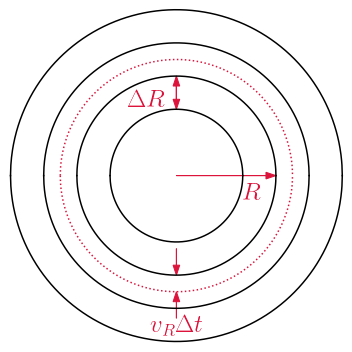

In [119]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-5.1, 5.1])
ax.axis("off")

def plot_circle(radius, **kwargs):
    xvals = np.linspace(-radius, radius, 1000)
    yvals = [np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)
    yvals = [-np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)

kwargs = {"c": named_colors()["black"]}
for _ in [2, 3, 4, 5]: plot_circle(_, **kwargs)
plot_circle(3.5, c = named_colors()["crimson"], linestyle = ':')
kwargs = {
    "color": named_colors()["crimson"],
    "length_includes_head": True,
    "head_width": 0.2
}
ax.arrow(0, 0, 3, 0, **kwargs)
ax.arrow(0, 2, 0, 1, **kwargs)
ax.arrow(0, 3, 0, -1, **kwargs)
ax.arrow(0, -4.3, 0, 0.8, **kwargs)
ax.arrow(0, -2.2, 0, -0.8, **kwargs)
ax.text(-1.5, 2.1, r"$\Delta R$", color = kwargs["color"], fontsize = 25)
ax.text(2, -0.7, r"$R$", color = kwargs["color"], fontsize = 25)
ax.text(-0.8, -4.7, r"$v_R \Delta t$", color = kwargs["color"], fontsize = 25)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./radialflows/schematic.%s" % (ext), **kwargs)
plt.show()

**Figure**: An illustration of the geometric scheme. Describing the Galactic disk as a series of rings of uniform radial width $\Delta R$, a disk of inner radius $R$ has neighboring rings at $R + \Delta R$ and $R - \Delta R$. Within a differential timestep $\Delta t$, a uniform radial flow of velocity $v_R$ will travel inward $v_R \Delta t$ inward, transfering $f = \left[\left(R + v_R \Delta t\right)^2 - R^2\right] / \left[\left(R + \Delta R\right)^2 - R^2\right]$ of the gas to the next ring in.

This radial advection of gas carries the metals in the ISM with it. Specifically, the mass *gained* in a given annulus is at the metallicity of the next ring while the mass *lost* is at the metallicity of the current ring:

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= \dot{M}_{\alpha,\text{flow,in}} - \dot{M}_{\alpha,\text{flow,out}}
\\
&= Z_\alpha(R + \Delta R)\dot{M}_{g,\text{flow,in}} - Z_\alpha(R)\dot{M}_{g,\text{flow,out}}
\\
&= Z_\alpha(R + \Delta R) M_g(R + \Delta R) \frac{f(R + \Delta R)}{\Delta t} -
Z_\alpha(R) M_g(R) \frac{f(R)}{\Delta t}.
\end{align}
$$

I apply this approximation to cases in which the rings are *narrow*, meaning that the width of each ring is small compared to the scale radius of the galactic disk, the galactic abundance gradient, etc. Furthermore, the timestep size must be small to ensure that the model Galaxy is well-resolved. It is therefore reasonable to approximate $Z_\alpha$, $M_g$, and $f$ at $R + \Delta R$ as perturbations of the ir values in the current ring at radius $R$:

$$
\begin{align}
Z_\alpha(R + \Delta R) &= Z_\alpha(R) + \frac{\partial Z_\alpha}{\partial R} \Delta R +
\frac{\partial^2 Z_\alpha}{\partial R^2} \Delta R^2 +
\frac{\partial^3 Z_\alpha}{\partial R^3} \Delta R^3 +~...
\\
&\approx Z_\alpha(R) + \frac{\partial Z_\alpha}{\partial R} \Delta R
\\
M_g(R + \Delta R) &= M_g(R) + \frac{\partial M_g}{\partial R} \Delta R +
\frac{\partial^2 M_g}{\partial R^2} \Delta R^2 +
\frac{\partial^3 M_g}{\partial R^3} \Delta R^3 +~...
\\
&\approx M_g(R) + \frac{\partial M_g}{\partial R} \Delta R
\\
f(R + \Delta R) &= + f(R) + \frac{\partial f}{\partial R} \Delta R +
\frac{\partial^2 f}{\partial R^2} \Delta R^2 +
\frac{\partial^3 f}{\partial R^3} \Delta R^3 +~...
\\
&\approx f(R) + \frac{\partial f}{\partial R} \Delta R.
\end{align}
$$

For choices about the Galactic abundance and surface density gradients, I can then obtain an expression for $\dot{M}_{\alpha,\text{flow}}$ as a function of radius $R$, the bulk flow velocity $v_R$, and the ring width $\Delta R$.

## The radial abundance gradient

Abundance gradients are typically parameterized as a linear decline in the logarithmic abundance [X/H] for some element X. This corresponds to an exponential decline in the mass fraction $Z_X$. Applying this to an alpha element for a given gradient slope $A$:

$$
\begin{align}
\text{[$\alpha$/H]} &= A\left(R - R_\odot\right)
\\
\implies Z_\alpha &= Z_{\alpha,\odot} 10^{A(R - R_\odot)}
\\
&= Z_{\alpha,\odot} e^{-(R - R_\odot) / R_\alpha},
\end{align}
$$

where $R_\alpha = -(A \ln 10)^{-1}$ is the e-folding scale radius of abundance gradient ($A < 0$ for a declining abundance gradient) and $R_\odot = 8$ kpc is an assumed Galactocentric distance of the Sun.

$$
\begin{align}
\frac{\partial Z_\alpha}{\partial R} &= Z_{\alpha,\odot}
\left(\frac{-1}{R_\alpha}\right)e^{-(R - R_\odot) / R_\alpha}
\\
&= \frac{-1}{R_\alpha} Z_\alpha(R)
\\
\implies Z_\alpha(R + \Delta R) &\approx Z_\alpha(R) \left(1 - \frac{\Delta R}{R_\alpha}\right).
\end{align}
$$

## The radial surface density gradient

The surface density of gas in the Galactic disk is typically parameterized as exponential:

$$
\Sigma_g(R) = \Sigma_{g,0} e^{-R / R_g},
$$

where $R_g$, similar to $R_\alpha$, is the e-folding scale radius of the gas disk. For thin rings, the mass can be approximated as $M_g \approx \Sigma_g(R) 2\pi R \Delta R$. In computing how the mass in the rings change with radius, there will therefore be terms which account for the area of the ring changing with radius in addition to the changes in surface density.

$$
\begin{align}
\frac{\partial M_g}{\partial R} &= 2\pi \Delta R \Sigma_g(R) +
2\pi R \Delta R \frac{\partial \Sigma_g(R)}{\partial R}
\\
&= 2\pi \Delta R \Sigma_g(R) + 2\pi R \Delta R \Sigma_{g,0}
\left(\frac{-1}{R_g}\right)e^{-R / R_g}
\\
&= 2\pi \Delta R \Sigma_g(R) - 2\pi \left(\frac{R}{R_g}\right) \Delta R \Sigma_{g}(R)
\\
&= 2\pi R\Delta R \Sigma_g(R) \left[\frac{1}{R} - \frac{1}{R_g}\right]
\\
&= M_g(R) \left[\frac{1}{R} - \frac{1}{R_g}\right]
\\
\implies M_g(R + \Delta R) &\approx M_g(R) \left[1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right].
\end{align}
$$

In the above expression, the $+\Delta R / R$ term accounts for the increasing area of the ring while the $-\Delta R / R_g$ term accounts for the decrease in surface density with increasing $R$.

## The flow fraction

As the inner radius of the ring $R$ changes, so too does the area fraction $f$ of gas that will leave the annulus in a given $\Delta t$ timestep.

$$
\begin{align}
\frac{\partial f}{\partial R} &= \frac{\partial}{\partial R}
\left[\frac{
    2R v_R \Delta t + v_R^2 \Delta t^2
}{
    2R \Delta R + \Delta R^2
}
\right]
\\
&= \frac{
    \left(2R \Delta R + \Delta R^2\right) 2v_R \Delta t -
    \left(2R v_R \Delta t + v_R^2 \Delta t^2\right) 2\Delta R
}{
    \left(2R \Delta R + \Delta R^2\right)^2
}
\\
&= \frac{
    4 R v_R \Delta R \Delta t + 2 v_R \Delta R^2 \Delta t -
    4 R v_R \Delta R \Delta t + 2 v_R^2 \Delta R \Delta t^2
}{
    \left(2R \Delta R + \Delta R^2\right)^2
}
\\
&= \frac{
    2 v_R \Delta R \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)^2
}
\\
&= f(R) \frac{
    2 v_R \Delta R \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)^2
} \left(\frac{
    2 R \Delta R + \Delta R^2
}{
    2 R v_R \Delta t + v_R^2 \Delta t^2
}\right)
\\
&= f(R) \frac{
    2 v_R \Delta R \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)\left(2 R v_R \Delta t + v_R^2 \Delta t^2\right)
}
\\
\implies f(R + \Delta R) &\approx f(R) \left[1 + \frac{
    2 v_R \Delta R^2 \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)\left(2 R v_R \Delta t + v_R^2 \Delta t^2\right)
}\right]
\\
&= f(R) \left[1 + \frac{
    2 v_R \Delta R \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R + \Delta R\right)\left(2 R v_R + v_R^2 \Delta t\right)
}\right]
\end{align}
$$

## The metal flow rate

Tying each of these terms together results in the following expression for the total flow rate:

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= Z_\alpha(R + \Delta R) M_g(R + \Delta R) \frac{f(R + \Delta R)}{\Delta t} -
Z_\alpha(R) M_g(R) \frac{f(R)}{\Delta t}
\\
&= Z_\alpha(R) M_g(R) \frac{f(R)}{\Delta t} \left[
\left(1 - \frac{\Delta R}{R_\alpha}\right)
\left(1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right)
\left(1 + \frac{
    2 v_R \Delta R \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R + \Delta R\right)\left(2 R v_R + v_R^2 \Delta t\right)
}\right) - 1\right]
\\
&= Z_\alpha(R) M_g(R) \frac{
    2 R v_R + v_R^2 \Delta t
}{
    2 R \Delta R + \Delta R^2
}\left[
\left(1 - \frac{\Delta R}{R_\alpha}\right)
\left(1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right)
\left(1 + \frac{
    2 v_R \Delta R \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R + \Delta R\right)\left(2 R v_R + v_R^2 \Delta t\right)
}\right) - 1\right].
\end{align}
$$

Now that I've obtained an expression for $\dot{M}_{\alpha,\text{flow}}$ given choices of $\Delta R$ and $\Delta t$, I take the limits as $\Delta R \rightarrow 0$ and $\Delta t \rightarrow 0$. For the timestep size, this is trivial as the few terms dependent on $\Delta t$ simply disappear:

$$
\lim_{\Delta t \rightarrow 0} \dot{M}_{\alpha,\text{flow}} = Z_\alpha(R) M_g(R) \frac{
    2 R v_R
}{
    2 R \Delta R + \Delta R^2
}\left[
\left(1 - \frac{\Delta R}{R_\alpha}\right)
\left(1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right)
\left(1 + \frac{
    2 v_R \Delta R^2
}{
    4 R^2 v_R + 2 R v_R \Delta R
}\right) - 1\right].
$$

Taking the limit as $\Delta R \rightarrow 0$ is significantly less trivial as both the quantity in square brackets and $2R\Delta R + \Delta R^2$ go to zero, resulting in the $0/0$ indeterminate form. I therefore apply L'Hopital's rule, taking the partial derivative with respect to $\Delta R$ of both quantities and then taking their limits as $\Delta R \rightarrow 0$. This results in the following expression for $\dot{M}_{\alpha,\text{flow}}$

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= Z_\alpha(R) M_g(R) \frac{2Rv_R}{2R}
\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)
\\
&= Z_\alpha \dot{M}_\star \tau_\star v_R
\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right),
\end{align}
$$

where I have substituted in for the star formation rate (SFR) $\dot{M}_\star$ and the star formation efficiency (SFE) timescale $\tau_\star \equiv M_g / \dot{M}_\star$ and dropped the notation of quantities as a function of radius $R$ for simplicity.

This expression makes intuitive sense. The linear proportion with $v_R$ is expected. As the local abundance by mass increases, so too does the flow rate in proportion. The same goes for the local star formation rate and SFE timescale, as they are tied to the local gas supply, and the more gas there is, the more that will be transferred between rings if the flow is uniform. If the metallicity gradient steepens (i.e., $R_\alpha$ decreases), then the metallicity of the next outer ring at $R + \Delta R$ decreases, and consequently so too does the flow rate. If the gas surface density gradient steepens (i.e., $R_g$ decreases), then a similar effect occurs: the *total* mass, and by extension the metal mass, is smaller at $R + \Delta R$, so the flow rate decreases.

The physical reason for the appearance of the $1 / R$ term is less intuitive. It arises in taking the derivative of the gas supply with respect to radius $\partial M_g / \partial R$, specifically from the change in area of an annulus with radius (recall that it's the *surface density* of gas which declines exponentially with radius as opposed to the gas supply $M_g$ itself). This term therefore encodes the "pile-up" of metals at small $R$ due to the inward flow.

## Impact on Enrichment Rates & Equilibrium Abundances

Before applying the above calculations to one-zone models, they must be extended to assess the impact of radial flows on the total gas supply at a radius $R$. By simply omitting the $Z_\alpha(R)$ and $Z_\alpha(R + \Delta R)$ terms, there is no factor of $(1 - \Delta R / R_\alpha)$ in the limit expressions above, and the expression simply loses the $1 / R_\alpha$ term:

$$
\dot{M}_{g,\text{flow}} = \dot{M}_\star \tau_\star v_R
\left(\frac{1}{R} - \frac{1}{R_g}\right).
$$

One can also arrive at this result by asserting that $\dot{M}_{g,\text{flow}}$ should have the same mathematical solution as $\dot{M}_{\alpha,\text{flow}}$ in the limiting case where the abundance gradient is flat (i.e., $R_\alpha \rightarrow \infty$). It compactifies notation to introduce the following dimensionless parameters:

$$
\begin{align}
\mu_\text{flow} &\equiv \tau_\star v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)
\\
\gamma_\text{flow} &\equiv \tau_\star v_R \left(\frac{1}{R} - \frac{1}{R_g}\right),
\end{align}
$$

allowing $\dot{M}_{\alpha,\text{flow}}$ and $\dot{M}_{g,\text{flow}}$ to be expressed as

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= Z_\alpha \dot{M}_\star \mu_\text{flow}
\\
\dot{M}_{g,\text{flow}} &= \dot{M}_\star \gamma_\text{flow}.
\end{align}
$$

The signs of these terms determine whether radial flows are a source or sink term of both metals and gas. Note that $v_R$ was previously defined to be positive for an inward flow, so instead assigning $v_R < 0$ for an inward flow would simply introduce minus signs on $\mu_\text{flow}$ and $\gamma_\text{flow}$.


<!-- 
The total enrichment rate of an alpha element can then be expressed as

$$
\begin{align}
\dot{M}_\alpha &= y_\alpha \dot{M}_\star - Z_\alpha \dot{M}_\star \left(1 + \eta - r\right) +
Z_\alpha \dot{M}_\star \mu_\text{flow}
\\
&= y_\alpha \dot{M}_\star - Z_\alpha \dot{M}_\star \left(1 + \eta - r - \mu_\text{flow}\right).
\end{align}
$$

Similarly, the change in the total gas supply becomes

$$
\begin{align}
\dot{M}_g &= \dot{M}_\text{in} - \dot{M}_\star \left(1 + \eta - r\right) + \dot{M}_\star \gamma_\text{flow}
\\
&= \dot{M}_\text{in} - \dot{M}_\star \left(1 + \eta - r - \gamma_\text{flow}\right).
\end{align}
$$

In fact, the same equilibrium expressions in [Weinberg, Andrews & Freudenburg (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...837..183W/abstract) now apply under the simple transformation that $1 + \eta - r \rightarrow 1 + \eta - r - \beta_\text{flow}$. The depletion time $\tau_\text{dep}$ is given by

$$
\tau_\text{dep} \equiv \frac{\tau_\star}{1 + \eta - r - \beta_\text{flow}},
$$

and the alpha element equilibrium abundance for an exponential SFH becomes

$$
Z_{\alpha,\text{eq}} = \frac{y_\alpha}{1 + \eta - r - \beta_\text{flow} - \tau_\star / \tau_\text{sfh}}.
$$ -->

By definition, $\mu_\text{flow} = \gamma_\text{flow} - \tau_\star v_R / R_\alpha$. Consequently, $0 < \gamma_\text{flow} < \tau_\star v_R / R_\alpha$ is an interesting region of parameter space in which radial flows are a *source* of gas ($\gamma_\text{flow} > 0$) but a *sink* of metals ($\mu_\text{flow} < 0$). In this region of parameter space, dilution is therefore expected to be a strong effect.

Below, I plot $\mu_\text{flow}$ as a function of radius $R$ for various choices of $\tau_\star$, $v_R$, $\nabla$[$\alpha$/H], and $R_g$. I pick ($\tau_\star$, $v_R$, $\nabla$[$\alpha$/H], $R_g$) = ($5$ Gyr, $0.7$ km s$^{-1}$, $-0.08$ kpc$^{-1}$, $4$ kpc) as a fiducial choice of parameters, plotted in black in all panels. Red and blue lines in each panel then denote a variation in the choice of one specific parameter. I do not plot $\gamma_\text{flow}$ since it is a simple linear transformation upward by a factor of $\tau_\star v_R / R_\alpha$ upward in each panel. For the fiducial choice of parameters, $\tau_\star v_R / R_\alpha = 0.65$ (i.e., $\gamma_\text{flow} = \mu_\text{flow} + 0.65$).

In general, $\mu_\text{flow} > 0$ within a Galactocentric radius of a few kpc, depending on the exact choice of $\nabla$[$\alpha$/H], but $\mu_\text{flow} < 0$ outside of this region. This suggests that radial flows are net sink of metals at most radii where disk stellar populations dominate, assuming GCE parameters typical of the Milky Way. Flows are a stronger sink at large radii, indicating that radial gas flows should generally steepen abundance gradients. For any given evolutionary history, the presence of inward radial flows will shift accretion toward large radii, and there are both observational (e.g., CHAOS?) and theoretical arguments (e.g., Vincenzo & Kobayashi 2020?, Sharda et al. 2021?, lots of other simulation results come up in a quick ADS query) suggesting the same thing. Admittedly, the gradient is *assumed* in these calculations, though the figure below indicates that changes in $\nabla$[$\alpha$/H], though still significant, are a smaller effect than changes in the other parameters.

In [116]:
def ralpha(A):
    r"""
    The e-folding scale radius of the metallicity gradient by mass.
    
    See :math:`R_\alpha` in notes above.
    """
    return -1 / (A * np.log(10))

def mu_flow(taustar, vr, A, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_ # vr now in kpc / Gyr
    return taustar * vr * (1 / R - 1 / rg - 1 / ralpha(A))

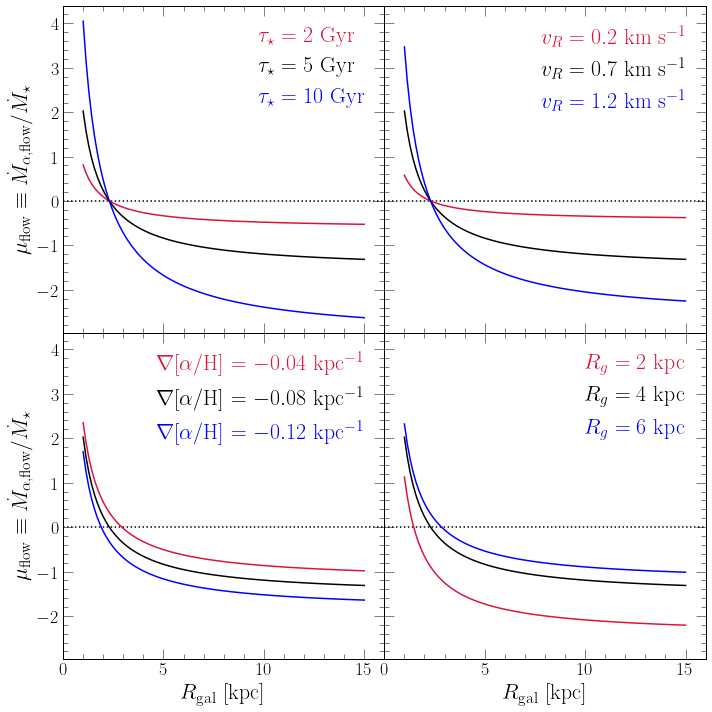

In [120]:
_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

fig = plt.figure(figsize = (10, 10))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i == 0 or i == 2:
        axes[i].set_ylabel(r"$\mu_\text{flow} \equiv \dot{M}_{\alpha,\text{flow}} / \dot{M}_\star$",
            fontsize = 22)
    else:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    if i >= 2:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 22)
    else:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    axes[i].set_xlim([0, 16])
    axes[i].axhline(0, c = named_colors()["black"], linestyle = ':')

colors = ["crimson", "black", "blue"]
taustar = [2, 5, 10]
vr = [0.2, 0.7, 1.2]
A = [-0.04, -0.08, -0.12]
rg = [2, 4, 6]

xvals = np.linspace(1, 15, 100)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\tau_\star = %g$ Gyr" % (taustar[i])
    }
    yvals = [mu_flow(taustar[i], vr[1], A[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$v_R = %g$ km s$^{-1}$" % (vr[i])
    }
    yvals = [mu_flow(taustar[1], vr[i], A[1], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\nabla$[$\alpha$/H] = $%g$ kpc$^{-1}$" % (A[i])
    }
    yvals = [mu_flow(taustar[1], vr[1], A[i], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$R_g = %g$ kpc" % (rg[i])
    }
    yvals = [mu_flow(taustar[1], vr[1], A[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)

for i in range(4):
    kwargs = {
        "loc": mpl_loc("upper right"),
        "handlelength": 0,
        "fontsize": 22
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./radialflows/muflow_vs_r.%s" % (ext), **kwargs)
plt.show()

The introduction of the terms $\mu_\text{flow}$ and $\gamma_\text{flow}$ complicate the solution to $Z_\alpha(t)$ for an exponential infall history from Weinberg, Andrews & Freudenburg (2017) as the enrichment rate depends on $\mu_\text{flow}$ but the depletion time $\tau_\text{dep}$ depends on $\gamma_\text{flow}$. In particular:

$$
\tau_\text{dep} = \frac{M_g}{\dot{M}_\star + \dot{M}_\text{out} - \dot{M}_\text{r} - \dot{M}_\text{flow}}
= \frac{\tau_\star}{1 + \eta - r - \gamma_\text{flow}}.
$$

The linear ODE for $Z_\alpha(t)$ is then given by:

$$
\begin{align}
\frac{y_\alpha}{\tau_\star} &=
\dot{Z}_\alpha + Z_\alpha\left(\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star} -
\frac{1}{\tau_\text{sfh}}\right)
\\
&= \dot{Z}_\alpha + Z_\alpha\left(\frac{\beta_\text{flow}}{\tau_\text{dep}} - \frac{1}{\tau_\text{sfh}}\right),
\end{align}
$$

where I have introduced the factor

$$
\beta_\text{flow} \equiv \frac{1 + \eta - r - \mu_\text{flow}}{1 + \eta - r - \gamma_\text{flow}}
$$

quantifying the ratio of the gas depletion time to the metal depletion time, now no longer equal to one due to the introduction of radial gas flows. In the presence of a negatively sloped abundance gradient (i.e., $A < 0$ and $R_\alpha > 0$), the metal depletion time will be shorter than the gas depletion time, because the surface density of metals falls off more steeply than the surface density of gas. The solution for $Z_\alpha(t)$ is given by:

$$
\begin{align}
Z_\alpha(t) &= \frac{y_\alpha}{\tau_\star}
\left(\frac{\beta_\text{flow}}{\tau_\text{dep}} - \frac{1}{\tau_\text{sfh}}\right)
\left[1 - \exp\left(
-t \left(\frac{\beta_\text{flow}}{\tau_\text{dep}} - \frac{1}{\tau_\text{sfh}}\right)\right)
\right]
\\
&= Z_{\alpha,\text{eq}} \left[1 - \exp\left(
-t \left(\frac{\beta_\text{flow}}{\tau_\text{dep}} - \frac{1}{\tau_\text{sfh}}\right)\right)
\right]
\\
&= Z_{\alpha,\text{eq}} \left[1 - \exp\left(
-t \left(\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star} - \frac{1}{\tau_\text{sfh}}\right)\right)
\right],
\end{align}
$$

where $Z_{\alpha,\text{eq}}$ is the equilibrium alpha element abundance:

$$
Z_{\alpha,\text{eq}} = \frac{y_\alpha}{\tau_\star}
\left(\frac{\beta_\text{flow}}{\tau_\text{dep}} - \frac{1}{\tau_\text{sfh}}\right)^{-1}
= \frac{y_\alpha}{1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}}.
$$

It compactifies notation to introduce a new timescale $\tau_\text{eq}$

$$
\tau_\text{eq} \equiv \left(\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star} -
\frac{1}{\tau_\text{sfh}}\right)^{-1},
$$

which describes the timescale on which a given Galactic region approaches its equilibrium abundance. This allows the alpha element abundance as a function of time to be written as

$$
Z_\alpha(t) = Z_{\alpha,\text{eq}}\left(1 - e^{-t / \tau_\text{eq}}\right).
$$

## Variations with Galactocentric Radius

Under this formalism, the radial abundance gradient $\nabla$[$\alpha$/H] at some time $T$ since the onset of star formation arises due to variations in the GCE parameters with radius. In principle, $\eta$, $\tau_\star$, $\tau_\text{sfh}$, and $\mu_\text{flow}$ can each vary with radius, and $Z_{\alpha,\text{eq}}$ may also vary with radius as a consequence. The gradient at a given time $t$ is then given by

$$
\begin{align}
\frac{\partial Z_\alpha}{\partial R} &=
\frac{\partial Z_{\alpha,\text{eq}}}{\partial R} \left(1 - e^{-t / \tau_\text{eq}}\right) +
Z_{\alpha,\text{eq}}\frac{\partial}{\partial R}\left(1 - e^{-t / \tau_\text{eq}}\right)
\\
&= \frac{\partial Z_{\alpha,\text{eq}}}{\partial R} \left(1 - e^{-t / \tau_\text{eq}}\right) +
Z_{\alpha,\text{eq}}\left(0 - e^{-t / \tau_\text{eq}}\right)\left(\frac{t}{\tau_\text{eq}^2}\right)
\frac{\partial \tau_\text{eq}}{\partial R}
\\
&= \frac{\partial Z_{\alpha,\text{eq}}}{\partial R} \left(1 - e^{-t / \tau_\text{eq}}\right) -
Z_{\alpha,\text{eq}}e^{-t / \tau_\text{eq}}\left(\frac{t}{\tau_\text{eq}^2}\right)
\frac{\partial \tau_\text{eq}}{\partial R}
\end{align}
$$

This expression indicates that there are two fundamental mechanisms which can drive radial abundance gradients in the Milky Way. The first occurs in the limiting case in which $t \gg \tau_\text{eq}$. In this case, the above expression simplifies to

$$
\frac{\partial Z_\alpha}{\partial R} \approx \frac{\partial Z_{\alpha,\text{eq}}}{\partial R},
$$

and the abundance gradient arises more or less entirely out of a decrease in the equilibrium abundance with radius. The Johnson et al. (2021) model for the Milky Way was in this regime and was driven by an increase in $\eta$ with radius. The second limiting case occurs when $t \ll \tau_\text{eq}$. Plausible instances of this case occur when the equilibrium abundance is considerably super-solar, but the timescale to reach it is much longer than a Hubble time anyway. In this case the expression for the gradient becomes

$$
\frac{\partial Z_\alpha}{\partial R} \approx -Z_{\alpha,\text{eq}}
\left(\frac{t}{\tau_\text{eq}^2}\right)
\frac{\partial \tau_\text{eq}}{\partial R}.
$$

I consider both limiting cases below before returning to the generalized expression to understand how the gradient can arise in the intermediate case in which $t$ is on the order of $\tau_\text{eq}$. First, however, I zoom in on variations with radius in each of $\tau_\star$, $\mu_\text{flow}$, and $\eta$.

### Star Formation Efficiency as a Function of Radius

In principle, the SFE timescale $\tau_\star$ can vary with radius in a complicated manner. However, this formalism is based on the ISM surface density falling off exponentially with radius:

$$
\Sigma_g \propto e^{-R / R_g}.
$$

Based on the definition of $\tau_\star$, a specific scaling of $\tau_\star$ with $R$ can be derived if a classic single power-law Kennicutt-Schmidt scaling of $\dot{\Sigma}_\star$ with $\Sigma_g$ is adopted:

$$
\begin{align}
\tau_\star &\equiv \frac{\Sigma_g}{\dot{\Sigma}_\star}
\\
&\propto \frac{\Sigma_g}{\Sigma_g^N}
\\
&\propto e^{(N - 1) R / R_g}.
\end{align}
$$

The above scaling suggests that $\tau_\star$ should also increase exponentially with radius if the gas disk falls off exponentially. If $N \approx 1.5$ as commonly adopted for the Kennicutt-Schmidt relation, then $N - 1 \approx 1/2$, and the scaling can be written as $\tau_\star \propto e^{R / 2R_g}$. In other words, $\tau_\star$ should have a scale radius that is approximately twice the scale radius of the gas disk under this parameterization. Letting $\tau_{\star,0}$ denote the overall normalization (i.e., the value of $\tau_\star$ at $R = 0$), then the derivative of $\tau_\star$ with respect to radius becomes:

$$
\begin{align}
\frac{\partial \tau_\star}{\partial R} &= \left(\frac{N - 1}{R_g}\right) \tau_{\star,0} e^{(N - 1) R / R_g}
\\
&= \left(\frac{N - 1}{R_g}\right) \tau_\star.
\end{align}
$$

### Radial Flows as a Function of Radius

Radial flows can in principle act as a source or sink term at any given radius, though the above illustrations show that they are a net sink term at $R_\text{gal} \gtrsim 3$ kpc for a broad range of parameter choices appropriate for the Milky Way. Taking the partial derivative of $\mu_\text{flow}$ with radius:

$$
\begin{align}
\frac{\partial \mu_\text{flow}}{\partial R} &= \frac{\partial}{\partial R}
\left[\tau_\star v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)\right]
\\
&= v_r\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)\frac{\partial \tau_\star}{\partial R} -
\frac{\tau_\star v_R}{R^2}.
\end{align}
$$

Substituting in $\partial \tau_\star / \partial R$ from above:

$$
\begin{align}
\frac{\partial \mu_\text{flow}}{\partial R} &= \tau_\star v_R
\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)\left(\frac{N - 1}{R_g}\right) -
\frac{\tau_\star v_R}{R^2}
\\
&= \mu_\text{flow}\left(\frac{N - 1}{R_g}\right) - \frac{\tau_\star v_R}{R^2}.
\end{align}
$$

### The Timescale to Reach Equilibrium

The equilibrium timescale $\tau_\text{eq}$ varies with radius as a consequence of variations in $\eta$, $\mu_\text{flow}$, $\tau_\star$, and $\tau_\text{sfh}$ with radius:

$$
\begin{align}
\frac{\partial \tau_\text{eq}}{\partial R} &= \frac{\partial}{\partial R}
\left(\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star} - \frac{1}{\tau_\text{sfh}}\right)^{-1}
\\
&= -\left(\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star} - \frac{1}{\tau_\text{sfh}}\right)^{-2}
\left[
\frac{\partial}{\partial R}\left(\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star}\right)
- \frac{\partial}{\partial R}\left(\frac{1}{\tau_\text{sfh}}\right)
\right]
\\
&= -\tau_\text{eq}^2\left[
\frac{1}{\tau_\star^2}\left(\tau_\star\left(\frac{\partial \eta}{\partial R}
- \frac{\partial\mu_\text{flow}}{\partial R}\right) -
\left(1 + \eta - r - \mu_\text{flow}\right)\frac{\partial \tau_\star}{\partial R}\right)
+ \frac{1}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R}
\right]
\\
&= \tau_\text{eq}^2\left[
\frac{1}{\tau_\star}\frac{\partial \mu_\text{flow}}{\partial R} -
\frac{1}{\tau_\star}\frac{\partial \eta}{\partial R} +
\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star^2}\frac{\partial \tau_\star}{\partial R} -
\frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R}
\right].
\end{align}
$$

Substituting the above into the expression for the abundance gradient when $t \ll \tau_\text{eq}$:

$$
\frac{\partial Z_\alpha}{\partial R} = tZ_{\alpha,\text{eq}}\left[
\frac{1}{\tau_\star}\frac{\partial \eta}{\partial R} -
\frac{1}{\tau_\star}\frac{\partial \mu_\text{flow}}{\partial R} +
\frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star^2}\frac{\partial \tau_\star}{\partial R} 
\right].
$$

Recall, however, that this formalism is based on a gradient which is exponential in $Z_\alpha$, and consequently, $\partial Z_\alpha / \partial R = -Z_\alpha / R_\alpha$. Substituting this into the above expression yields the following expression for $Z_\alpha$ as a function of radius:

$$
Z_\alpha = t Z_{\alpha,\text{eq}} R_\alpha \left[
\frac{1}{\tau_\star}\frac{\partial \mu_\text{flow}}{\partial R} -
\frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star^2}\frac{\partial \tau_\star}{\partial R} -
\frac{1}{\tau_\star}\frac{\partial \eta}{\partial R}
\right].
$$

This expression indicates that when $t \ll \tau_\text{eq}$, the normalization of the gradient should grow approximatley linearly with time $t$, regardless of whether or not the term in square brackets is dominated by variations with radius in one of $\mu_\text{flow}$, $\eta$, $\tau_\star$, or $\tau_\text{sfh}$.

Now substituting in the expressions for $\partial \tau_\star / \partial R$ and $\partial \mu_\text{flow} / \partial R$ from above:

$$
\begin{align}
Z_\alpha &= t Z_{\alpha,\text{eq}} R_\alpha \left[
\frac{\mu_\text{flow}}{\tau_\star}\left(\frac{N - 1}{R_g}\right) -
\frac{v_R}{R^2} +
\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star}\left(\frac{N - 1}{R_g}\right) -
\frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
\frac{1}{\tau_\star}\frac{\partial \eta}{\partial R}
\right]
\\
&= t Z_{\alpha,\text{eq}} R_\alpha \left[
\frac{-v_R}{R^2} +
\frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g}\right) -
\frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
\frac{1}{\tau_\star}\frac{\partial \eta}{\partial R}
\right].
\end{align}
$$

Interestingly, all terms depending on $\mu_\text{flow}$ cancel in the above expression, leaving behind only a $-v_R / R^2$ term, indicating that the flow velocity itself is all that matters in setting the normalization of the gradient in the $t \ll \tau_\text{eq}$ regime.

### Optimizing the Metallicity Distribution Function

While the above argument describes the origin of the *gas-phase* abundance gradient, in the $t \ll \tau_\text{eq}$ regime, the observed stellar MDF will arise as a consequence of shifts in the peak of the MDF as a function of radius. That is, the maximum in the MDF dN/d[$\alpha$/H] will not necessarily occur at the present-day. When parameterized by time, dN/d[$\alpha$/H] is at a maximum or minimum when the following condition is satisfied:

$$
\frac{\ddot{M}_\star}{\dot{M}_\star} = \frac{\ddot{Z}_\alpha}{\dot{Z}_\alpha} -
\frac{\dot{Z}_\alpha}{Z_\alpha}.
$$

Given the solution to $Z_\alpha(t)$ for an exponential SFH under this steady-state radial flow argument, $\dot{Z}_\alpha$ and $\ddot{Z}_\alpha$ are given by

$$
\begin{align}
\dot{Z}_\alpha &= \frac{1}{\tau_\text{eq}}Z_{\alpha,\text{eq}}e^{-t / \tau_\text{eq}}
\\
\implies \frac{\dot{Z}_\alpha}{Z_\alpha} &=
\frac{e^{-t / \tau_\text{eq}}}{\tau_\text{eq}\left(1 - e^{-t / \tau_\text{eq}}\right)}
\\
\ddot{Z}_\alpha &= \frac{-1}{\tau_\text{eq}^2} Z_{\alpha,\text{eq}}e^{-t / \tau_\text{eq}}
\\
\implies \frac{\ddot{Z}_\alpha}{\dot{Z}_\alpha} &= \frac{-1}{\tau_\text{eq}}.
\end{align}
$$

Plugging this into the optimization criterion above and solving for the time $t_\text{max}$ which satisfies the condition:

$$
\begin{align}
\frac{-1}{\tau_\text{sfh}} &= \frac{-1}{\tau_\text{eq}} -
\frac{e^{-t_\max / \tau_\text{eq}}}{\tau_\text{eq}\left(1 - e^{-t_\max / \tau_\text{eq}}\right)}
\\
\implies t_\max &= -\tau_\text{eq} \ln \left(1 - \frac{\tau_\text{sfh}}{\tau_\text{eq}}\right).
\end{align}
$$

The mode of the [$\alpha$/H] distribution then occurs at

$$
\begin{align}
\text{mode([$\alpha$/H])} &= \log_{10}\left(\frac{Z_\alpha(t_\text{max})}{Z_{\alpha,\odot}}\right)
\\
&= \log_{10}\left[
\frac{Z_{\alpha,\text{eq}}}{Z_{\alpha,\odot}}
\left(\frac{\tau_\text{sfh}}{\tau_\star}\left(1 + \eta - r - \mu_\text{flow}\right) - 1\right)
\right].
\end{align}
$$

This result, however, assumes that (1) the Galactic region has had enough time to produce the maximum (i.e., $t > t_\max$) and that (2) the position of the maximum is below the equilibrium abundance. If either of these conditions are not met, the MDF will instead monotonically rise up to [$\alpha$/H] of the present day (or, more generally, the time of observation) at which there will be a hard cutoff as no stars will have formed at that metallicity.

The above expression, however, simplifies in an interesting way:

$$
\begin{align}
\text{mode([$\alpha$/H])} &= \log_{10}\left[
\frac{y_\alpha}{Z_{\alpha,\odot}\left(1 + \eta - r - \mu_\text{flow} - \tau_\star / \tau_\text{sfh}\right)}
\left(\frac{\tau_\text{sfh}}{\tau_\star}\right)\left(1 + \eta - r - \mu_\text{flow} -
\frac{\tau_\star}{\tau_\text{sfh}}\right)
\right]
\\
&= \log_{10}\left[
\frac{y_\alpha}{Z_{\alpha,\odot}}\left(\frac{\tau_\text{sfh}}{\tau_\star}\right)
\right].
\end{align}
$$

The above indicates that in the $t \ll \tau_\text{eq}$ regime, the stellar metallicity gradient is surprisingly simple. It is set *only* by the SFE timescale and the shape of the SFH. Furthermore, if the relationship between mode([$\alpha$/H]) and R is linear, then the relationship between the ratio $\tau_\text{sfh} / \tau_\star$ and radius must be exponential. As shown above, $\tau_\star$ increases with radius if the gas disk is exponential and the $\dot{\Sigma}_\star - \Sigma_\text{g}$ relation is a single power-law. As a result, the relationship between $\tau_\text{sfh}$ and radius must also be exponential.

The above expression provides the interesting realization that in the more general case, a relationship between $\tau_\star$ and $\tau_\text{sfh}$ can be derived which would produce a given stellar abundance gradient mode([$\alpha$/H]) as a function of $R$:

$$
\begin{align}
\frac{\tau_\text{sfh}}{\tau_\star} &= \frac{Z_{\alpha,\odot}}{y_\alpha} 10^{A(R - R_\odot)}
\\
\implies \tau_\text{sfh} &= \tau_\star \frac{Z_{\alpha,\odot}}{y_\alpha} e^{-(R - R_\odot) / R_\alpha}
\\
&= \tau_{\star,0} \frac{Z_{\alpha,\odot}}{y_\alpha} e^{(N - 1)R / R_g} e^{-(R - R_\odot) / R_\alpha}
\\
&= \tau_{\star,0} e^{R_\odot / R_\alpha} \frac{Z_{\alpha,\odot}}{y_\alpha} e^{R / R_\text{sfh}},
\end{align}
$$

where

$$
R_\text{sfh} \equiv \left(\frac{N - 1}{R_g} - \frac{1}{R_\alpha}\right)^{-1}
$$

is the spatial scale on which $\tau_\text{sfh}$ e-folds. For $N = 1.5$, $R_g = 2$ kpc, $A = -0.08$ dex/kpc, $R_\text{sfh} = 15.3$ kpc.

In [2]:
def reference_gradient(r, slope = -0.08, rsun = 8):
    return slope * (r - rsun)

class exponential:
    
    def __init__(self, norm = 10, timescale = 1):
        self.norm = norm
        self.timescale = timescale
        
    def __call__(self, time):
        return self.norm * np.exp(-time / self.timescale)
    
def mode(bins, dist):
    idxmax = dist.index(max(dist))
    return (bins[idxmax] + bins[idxmax + 1]) / 2

In [3]:
radii = list(range(1, 15))
taustar0 = 2 # Gyr
A = -0.08 # dex/kpc
Rg = 2. # kpc
N = 1.5 # kennicutt-schmidt power-law index

vice.yields.ccsne.settings['o'] = 2 * vice.solar_z['o']

def taustar(r):
    return taustar0 * np.exp((N - 1) * r / Rg)

def tausfh(r):
    ralpha = -1 / (A * np.log(10))
    tausfh0 = taustar0 * np.exp(8 / ralpha) * vice.solar_z['o'] / vice.yields.ccsne.settings['o']
    Rsfh = 1 / ((N - 1) / Rg - 1 / ralpha)
    return tausfh0 * np.exp(r / Rsfh)

def zeq(r, eta = 0, muflow = 0):
    return vice.yields.ccsne.settings['o'] / (1 + eta - 0.4 - taustar(r) / tausfh(r) - muflow)

In [4]:
for r in radii:
#     print(r, tausfh(r))
    print(r, 0.01 / (1 + 2 - 0.4 - taustar(r) / tausfh(r)), bool(tausfh(r) < 2 * taustar(r) / (1 + 2 - 0.4)))

1 0.004880062081445294 False
2 0.005160657041282143 False
3 0.005543895945007714 False
4 0.006087391263381937 False
5 0.006900739162498709 False
6 0.008221398593011128 True
7 0.010678370641619785 True
8 0.016666666666666663 True
9 0.05115844964345822 True
10 -0.034378492033892386 True
11 -0.011420718444693287 True
12 -0.0063347580262301155 True
13 -0.004125799142558081 True
14 -0.002907058343958234 True


In [5]:
radii = list(range(1, 15))
for i in range(len(radii)):
    sys.stdout.write("\rR = %g kpc       " % (radii[i]))
    with vice.singlezone(name = "./outputs/r_%d_kpc" % radii[i], elements = ['o']) as sz:
        sz.mode = "sfr"
        sz.func = exponential()
        sz.func.timescale = tausfh(radii[i])
        sz.tau_star = taustar(radii[i])
        sz.eta = 0
        sz.bins = np.linspace(-3, 2, 401)
        sz.dt = 0.001
#         sz.schmidt = True
#         sz.MgSchmidt = sz.tau_star * sz.func.norm / np.e * 1e9
        sz.run(np.linspace(0, 13.2, 13201), overwrite = True)
sys.stdout.write("\n")

R = 1 kpc       

/var/home/johnson.7419.local/VICE/vice/core/singlezone/singlezone.py:914: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version.eta = value
/var/home/johnson.7419.local/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


R = 14 kpc       


1

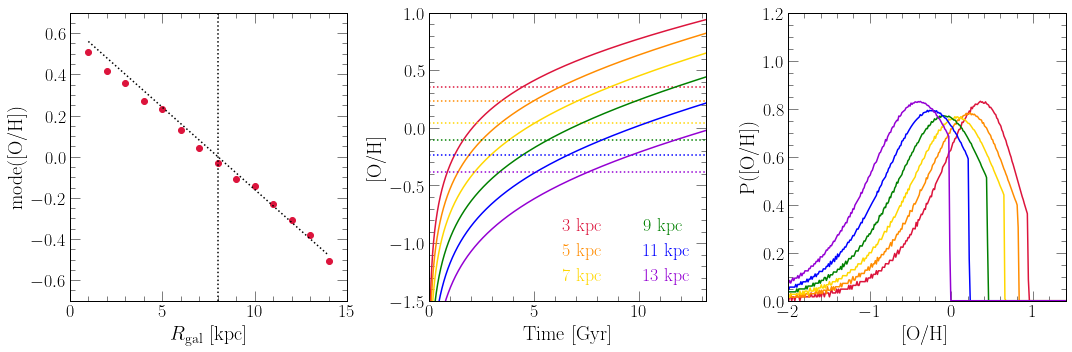

In [6]:
fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3): axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel(r"$R_\text{gal}$ [kpc]")
axes[0].set_ylabel(r"mode([O/H])")
axes[0].set_xlim([0, 15])
axes[0].set_ylim([-0.7, 0.7])
axes[1].set_xlabel(r"Time [Gyr]")
axes[1].set_ylabel(r"[O/H]")
axes[1].set_xlim([0, 13.2])
axes[1].set_ylim([-1.5, 1])
axes[2].set_xlabel(r"[O/H]")
axes[2].set_ylabel(r"P([O/H])")
axes[2].set_xlim([-2, 1.4])
axes[2].set_ylim([0, 1.2])

special = [3, 5, 7, 9, 11, 13]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

radii = list(range(1, 15))
for i in range(len(radii)):
    out = vice.output("./outputs/r_%d_kpc" % (radii[i]))
    modeoh = mode(out.mdf["bin_edge_left"] + [out.mdf["bin_edge_right"][-1]], out.mdf["dn/d[o/h]"])
    axes[0].scatter(radii[i], modeoh, c = named_colors()["crimson"], marker = markers()["circle"])
    if radii[i] in special:
        kwargs = {"c": named_colors()[colors[special.index(radii[i])]]}
        axes[1].axhline(modeoh, linestyle = ':', **kwargs)
        kwargs["label"] = "%d kpc" % (radii[i])
        axes[1].plot(out.history["time"], out.history["[o/h]"], **kwargs)
        centers = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
        axes[2].plot(centers, out.mdf["dn/d[o/h]"], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": ':'
}
axes[0].plot(radii, [reference_gradient(r) for r in radii], **kwargs)
axes[0].axvline(8, **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 2,
    "handlelength": 0
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
# plt.savefig("./radialflows/tllteq_schmidt.pdf")
# plt.savefig("./radialflows/tllteq.pdf")
# plt.savefig("./radialflows/tllteq_consteta3.pdf")
plt.show()

**Figure**: The radial abundance gradient predicted by a series of one-zone models in which $t \ll \tau_\text{eq}$, $\eta = 0$, and $\tau_\star$ and $\tau_\text{sfh}$ increase with radius according to the above formalism. **Left**: mode([O/H]) as a function of radius (red points) in each one-zone model. Dotted black lines denote $R_\odot = 8$ kpc and a reference gradient of $\nabla$[O/H] = $-0.08$ dex/kpc. **Middle**: [O/H] versus time at a selection of radii, color-coded according to the legend. **Right**: the [O/H] MDFs as the same radii as the middle panel.

### What happens if $\eta \neq 0$ in this class of models?

Here, I consider a few test cases in which $\eta \neq 0$, but is independent of both time and Galactocentric radius. I do not consider cases in which $\eta \propto e^R$ as in Johnson et al. (2021), because these cases generally do not fall into the $t \ll \tau_\text{eq}$ regime due to $\tau_\text{eq}$ decreasing as $\eta$ increases. Consequently, this class of models generally falls into the $t \gg \tau_\text{eq}$ limit, or at least beyond some radius at which $\eta$ becomes sufficiently large. Maintaining $t \ll \tau_\text{eq}$ with $\eta \propto e^R$ would require sufficiently large stellar yields for the equilibrium abundance to be super-solar at large $\eta$ as well as a long enough $\tau_\star$ to not get there. While highly inefficient star formation is plausible *prima facie*, these SN yields would be considerably larger than theoretical predictions (e.g., Sukhbold et al. 2016, Limongi & Chieffi 2018, among others)

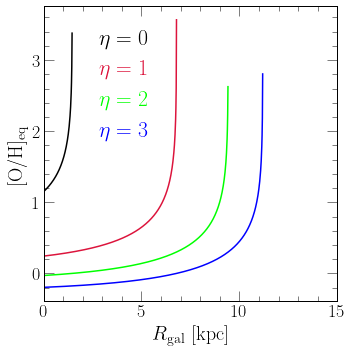

In [5]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"[O/H]$_\text{eq}$")
# ax.set_ylabel(r"$\log_{10}(Z_\text{O,eq} / Z_{\text{O},\odot})$")
ax.set_xlim([0, 15])
# ax.set_ylim([-0.7, 0.7])

etas = [0, 1, 2, 3]
colors = ["black", "crimson", "lime", "blue"]
radii = np.linspace(0, 15, 1000)
for i in range(len(etas)):
    yvals = len(radii) * [0.]
    for j in range(len(radii)):
        zeq_ = zeq(radii[j], eta = etas[i])
        if zeq_ > 0:
            yvals[j] = np.log10(zeq_ / vice.solar_z['o'])
        else:
            yvals[j] = float("nan")
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\eta = %g$" % (etas[i])
    }
    ax.plot(radii, yvals, **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.1, 0.99),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 22
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.savefig("./radialflows/zeq_vs_r_consteta.pdf")
plt.show()

**Figure**: The equilibrium [O/H] $\equiv \log_{10}(Z_\text{O,eq} / Z_{\text{O},\odot})$ as a function of radius for $y_\text{O}^\text{CC} = 2 Z_{\text{O},\odot}$, $\tau_\star = (\text{2 Gyr})e^{(N - 1)R / \text{2 kpc}}$, and $\tau_\text{sfh}$ given by the MDF optimization criteria above for different choices of $\eta$. With increasing radius, the ratio $\tau_\star / \tau_\text{sfh}$ increases, thereby increasing $Z_\text{O,eq}$, up to a point where the equilibrium abundance diverges to infinity. Beyond this radius, the equilibrium abundance is negative, and the abundance evolution proceeds as $Z_\alpha = -Z_{\alpha,\text{eq}} \left(e^{-t / \tau_\text{eq}} - 1\right)$ (i.e., *unlimited* exponential growth as opposed to *limited* exponential growth). As $\eta$ increases, the equilibrium abundance decreases at all radii, and the radius at which the equilibrium abundance diverges increases.

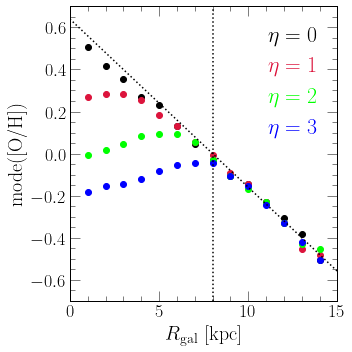

In [37]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"mode([O/H])")
ax.set_xlim([0, 15])
ax.set_ylim([-0.7, 0.7])

suffixes = ["", "_consteta1", "_consteta2", "_consteta3"]
labels = [r"$\eta = %d$" % (_) for _ in range(4)]
colors = ["black", "crimson", "lime", "blue"]
radii = range(1, 15)
for i in range(len(suffixes)):
    for j in range(len(radii)):
        kwargs = {"c": named_colors()[colors[i]]}
        if not j: kwargs["label"] = labels[i]
        with vice.output("./outputs/r_%d_kpc%s" % (radii[j], suffixes[i])) as out:
            modeoh = mode(out.mdf["bin_edge_left"] + [out.mdf["bin_edge_right"][-1]],
                out.mdf["dn/d[o/h]"])
            ax.scatter(radii[j], modeoh, **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": ':'
}
ax.plot([0, 15], [reference_gradient(r) for r in [0, 15]], **kwargs)
ax.axvline(8, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 22
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.show()

**Figure**: The effect of $\eta \neq 0$ on the predicted mode of [O/H] distribution (computed with VICE). The observational signature of this scenario is either a flattening or slight inversion of the gradient at the radii small enough to achieve the equilibrium abundance. Whether this slight inversion would be detected with statistical significance is a question of sample size and measurement precision.

R = 14 kpc      


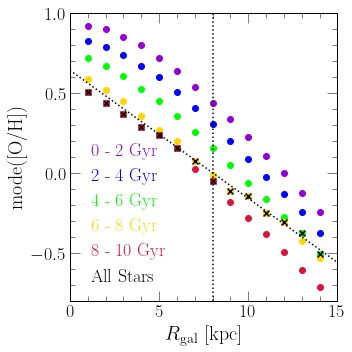

In [16]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"mode([O/H])")
ax.set_xlim([0, 15])
ax.set_ylim([-0.8, 1])
ax.set_yticks([-0.5, 0, 0.5, 1])

age_bins = [[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], None]
colors = ["darkviolet", "blue", "lime", "gold", "crimson", "black"]

kwargs = {
    "c": named_colors()["black"],
    "linestyle": ":"
}
ax.plot(ax.get_xlim(), [reference_gradient(_) for _ in ax.get_xlim()], **kwargs)
ax.axvline(8, **kwargs)

def binnum(bins, value):
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]: return i
    return -1

def find(arr, value):
    diff = [abs(_ - value) for _ in arr]
    return diff.index(min(diff))

def modemdf(output, agebin = None):
    if agebin is not None:
        idxmin = find(out.history["lookback"], agebin[1])
        idxmax = find(out.history["lookback"], agebin[0])
        oh = out.history["[o/h]"][idxmin:idxmax]
        sfr = out.history["sfr"][idxmin:idxmax]
    else:
        oh = out.history["[o/h]"][:]
        sfr = out.history["sfr"][:]
    bins = np.linspace(-3, 2, 501)
    dist = (len(bins) - 1) * [0.]
    for i in range(len(oh)):
        bin_ = binnum(bins, oh[i])
        if bin_ != -1: dist[bin_] += sfr[i]
    idxmax = dist.index(max(dist))
    return (bins[idxmax] + bins[idxmax + 1]) / 2

radii = range(1, 15)
for i in range(len(radii)):
    sys.stdout.write("\rR = %d kpc      " % (radii[i]))
    with vice.output("./outputs/r_%d_kpc" % (radii[i])) as out:
        for j in range(len(age_bins)):
            kwargs = {"c": named_colors()[colors[j]]}
            if age_bins[j] is None: kwargs["marker"] = markers()["x"]
            if not i:
                if age_bins[j] is not None:
                    kwargs["label"] = "%d - %d Gyr" % (age_bins[j][0], age_bins[j][1])
                else:
                    kwargs["label"] = "All Stars"
            mode = modemdf(out, agebin = age_bins[j])
            ax.scatter(radii[i], mode, **kwargs)
sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./radialflows/tllteq_grad_v_age.%s" % (ext), **kwargs)
plt.show()

**Figure**: mode([O/H]) as a function of radius in bins of age, predicted by this fiducial choice of evolutionary parameters for the $t \ll \tau_\text{eq}$ limit. As suggested by the analytic arguments above, the normalization of the gradient indeed grows with time in this scenario, and this leaves an observable signature in the stellar gradient as a function of age, which is contrary to what is seen in APOGEE.

### Variations in the Equilibrium Abundance

I now turn my attention to the $t \gg \tau_\text{eq}$ limiting case. In this scenario, $Z_\alpha \approx Z_{\alpha,\text{eq}}$. In cases where the late-time SFH decays exponentially with time (i.e., $\dot{M}_\star \propto e^{-t / \tau_\text{sfh}}$, the equilibrium abundance is given by

$$
Z_{\alpha,\text{eq}} = \frac{y_\alpha}{1 + \eta - r - \mu_\text{flow} - \tau_\star / \tau_\text{sfh}}.
$$

However, we can assert empirically from our APOGEE results that

$$
Z_{\alpha,\text{eq}} = Z_{\alpha,\odot} e^{-(R - R_\odot) / R_\alpha}.
$$

In the limit that $\eta$, $\mu_\text{flow}$, and $\tau_\star$ are independent of time, the e-folding timescale $\tau_\text{sfh}$ is uniquely specified:

$$
\begin{align}
\tau_\text{sfh} &= \tau_\star \left(
1 + \eta - r - \mu_\text{flow} - \frac{y_\alpha}{Z_{\alpha,\text{eq}}}
\right)^{-1}
\\
&= \left[\tau_\star^{-1}
\left(1 + \eta - r - \frac{y_\alpha}{Z_{\alpha,\text{eq}}}\right) -
v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)
\right]^{-1}
\\
&= \left[\frac{e^{(N - 1)R / R_g}}{\tau_\star}
\left(1 + \eta - r - \frac{y_\alpha}{Z_{\alpha,\odot}} e^{(R - R_\odot) / R_\alpha}\right) -
v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)
\right]^{-1}.
\end{align}
$$

Based on our APOGEE results, we can assert that equilibrium was reached some $\sim$$7 - 8$ Gyr ago. Indeed the lack of evolution in [O/H] with stellar age limits on the variability of the Galactic SFH over the last $\sim$8 Gyr as bursts in star formation would perturb the Galaxy from chemical equilibrium, and we do not see signatures of such evolutionary histories in our sample. If the Galactic SFH was indeed exponential over the last $\sim$8 Gyr, then we can easily predict the median age of $\lesssim$8 Gyr old stars. Letting the maximum age be a free parameter for generality:

$$
\begin{align}
\int_0^{\tau_\text{N}} e^{(\tau - \tau_\text{disk}) / \tau_\text{sfh}} d\tau
&= \frac{N}{100} \int_0^{\tau_\text{disk}} e^{(\tau - \tau_\text{disk}) / \tau_\text{sfh}} d\tau
\\
\tau_\text{sfh} e^{(\tau - \tau_\text{disk}) / \tau_\text{sfh}} \Big|_0^{\tau_\text{N}}
&= \tau_\text{sfh} \frac{N}{100} e^{(\tau - \tau_\text{disk}) / \tau_\text{sfh}} \Big|_0^{\tau_\text{disk}}
\\
e^{(\tau_\text{N} - \tau_\text{disk}) / \tau_\text{sfh}} - e^{-\tau_\text{disk} / \tau_\text{sfh}}
&= \frac{N}{100}\left(1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}\right)
\\
\frac{\tau_\text{N} - \tau_\text{disk}}{\tau_\text{sfh}}
&= \ln \left[
\frac{N}{100}\left(1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}\right) +
e^{-\tau_\text{disk} / \tau_\text{sfh}}
\right]
\\
\therefore \tau_\text{N} &= \tau_\text{disk} + \tau_\text{sfh}
\ln\left[
\frac{N}{100}\left(1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}\right) +
e^{-\tau_\text{disk} / \tau_\text{sfh}}
\right].
\end{align}
$$

In comparing to our APOGEE data, we then set $\tau_\text{disk} = 8$ Gyr to test different parameter choices.

In [2]:
_SECONDS_PER_GYR_ = 3.1536e16 # conversion factor
_KM_PER_KPC_ = 3.24e-17 # conversion factor
taudisk = 8

def tausfh(r, taustar0 = 2, Rg = 2, eta = 0, yieldsolar = 2, A = -0.08, vr = 0, N = 1.5):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_ # now in kpc / Gyr
    ralpha = -1 / (A * np.log(10))
    taustar = taustar0 * np.exp((N - 1) * r / Rg)
    term1 = (1 + eta - 0.4) - yieldsolar * np.exp((r - 8) / ralpha)
    flowterm = vr * (1 / r - 1 / Rg - 1 / ralpha)
    muflow = flowterm * taustar
    tausfh = (term1 / taustar - flowterm)**(-1)
    return tausfh

def tau50(r, **kwargs):
    tausfh_ = tausfh(r, **kwargs)
    return tau50_from_tausfh(tausfh_)

def tau50_from_tausfh(tausfh_):
    prefactor = np.log(0.5 * (1 - np.exp(-taudisk / tausfh_)) + np.exp(-taudisk / tausfh_))
    return taudisk + tausfh_ * prefactor

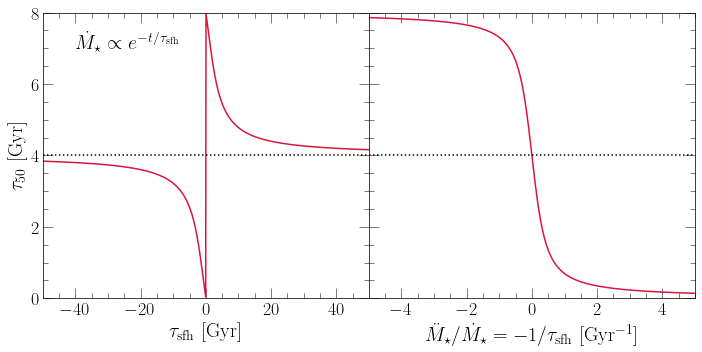

In [5]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax1.set_xlabel(r"$\tau_\text{sfh}$ [Gyr]")
ax1.set_ylabel(r"$\tau_{50}$ [Gyr]")
ax1.set_xlim([-50, 50])
ax1.set_ylim([0, 8])
ax2 = fig.add_subplot(122, sharey = ax1)
ax2.set_xlabel(r"$\ddot{M}_\star / \dot{M}_\star = -1 / \tau_\text{sfh}$ [Gyr$^{-1}$]")
# ax2.set_ylabel(r"$\tau_\text{50}$ [Gyr]")
ax2.set_xlim([-5, 5])
plt.setp(ax2.get_yticklabels(), visible = False)

xvals = np.linspace(-50, 50, 1000)
yvals = [tau50_from_tausfh(_) for _ in xvals]
ax1.plot(xvals, yvals, c = named_colors()["crimson"])
ax1.axhline(taudisk / 2, c = named_colors()["black"], linestyle = ':')
ax1.text(-40, 7, r"$\dot{M}_\star \propto e^{-t / \tau_\text{sfh}}$", fontsize = 20)

xvals = np.linspace(-5, 5, 1000)
yvals = [tau50_from_tausfh(-1 / _) for _ in xvals]
ax2.plot(xvals, yvals, c = named_colors()["crimson"])
ax2.axhline(taudisk / 2, c = named_colors()["black"], linestyle = ':')

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./radialflows/tau50_vs_tausfh.%s" % (ext), **kwargs)
plt.show()

**Figure**: The median of the age distribution $\tau_\text{50}$ as a function of the e-folding timescale $\tau_\text{sfh}$ of an exponential SFH $\dot{M}_\star \propto e^{-t / \tau_\text{sfh}}$ assuming the age of the Galactic disk $\tau_\text{disk} = 13.2$ Gyr. As $\tau_\text{sfh} \rightarrow \pm \infty$, $\dot{M}_\star \rightarrow$ constant, and $\tau_{50} \rightarrow \tau_\text{disk} / 2$ as a consequence. For sharply declining SFHs, $\tau_\text{50}$ is high as most of the stellar mass is assembled at long lookback times. The SFH *grows* with time for $\tau_\text{sfh} < 0$, but has otherwise similar effects on the median age.

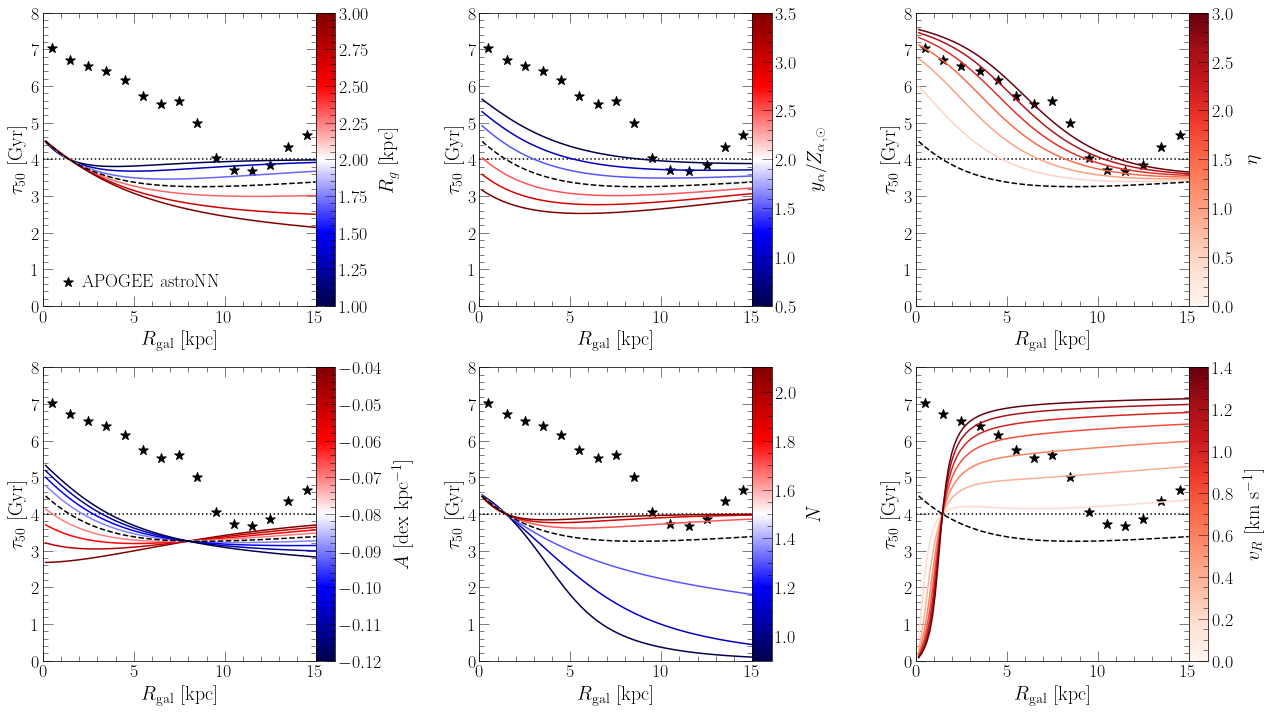

In [8]:
fig = plt.figure(figsize = (18, 10))
axes = []
for i in range(6):
    axes.append(fig.add_subplot(231 + i))
    axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_ylabel(r"$\tau_{50}$ [Gyr]")
    axes[i].set_xlim([0, 15])
    axes[i].set_ylim([0, taudisk])
    axes[i].axhline(taudisk / 2, c = named_colors()["black"], linestyle = ":")
plt.tight_layout()
plt.subplots_adjust(wspace = 0.6, right = 0.92)

def plot_behavior(ax, values, keywordarg, label, colormap):
    xvals = np.linspace(0, 15, 100)
    for i in range(len(values)):
        kwargs = {keywordarg: values[i]}
        yvals = [tau50(_, **kwargs) for _ in xvals]
        cm = plt.get_cmap(colormap)
        cnorm = colors.Normalize(vmin = min(values), vmax = max(values))
        sc = cmx.ScalarMappable(norm = cnorm, cmap = cm)
        kwargs = {"c": sc.to_rgba(values[i])}
        ax.plot(xvals, yvals, **kwargs)
    yvals = [tau50(_) for _ in xvals]
    kwargs = {
        "c": named_colors()["black"],
        "linestyle": "--"
    }
    ax.plot(xvals, yvals, **kwargs)
    cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
    cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "vertical")
    cbar.set_label(label, labelpad = 10)
    cbar_ax.set_position([
        ax.get_position().x1,
        ax.get_position().y0,
        0.015,
        ax.get_position().y1 - ax.get_position().y0
    ])

Rg_values = [1, 1.3, 1.7, 2, 2.3, 2.7, 3]
yieldratios = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
eta_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
slopes = [-0.04, -0.05, -0.06, -0.07, -0.08, -0.09, -0.10, -0.11, -0.12]
indeces = [0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1]
velocities = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

plot_behavior(axes[0], Rg_values, "Rg", r"$R_g$ [kpc]", "seismic")
plot_behavior(axes[1], yieldratios, "yieldsolar", r"$y_\alpha / Z_{\alpha,\odot}$", "seismic")
plot_behavior(axes[2], eta_values, "eta", r"$\eta$", "Reds")
plot_behavior(axes[3], slopes, "A", r"$A$ [dex kpc$^{-1}$]", "seismic")
plot_behavior(axes[4], indeces, "N", r"$N$", "seismic")
plot_behavior(axes[5], velocities, "vr", "$v_R$ [km s$^{-1}$]", "Reds")

data = np.genfromtxt("./medianage_vs_r.out")
radii = [row[0] for row in data]
med_age = [row[1] for row in data]
kwargs = {
    "c": named_colors()["black"],
    "marker": markers()["star"],
    "s": 100,
    "label": "APOGEE astroNN"
}
for i in range(6): axes[i].scatter(radii, med_age, **kwargs)
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 1
}
axes[0].legend(**kwargs)

for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./radialflows/tau50_reqd.%s" % (ext), **kwargs)
plt.show()

**Figure**: The median stellar age required to reproduce the observed radial abundance gradient assuming the $t \gg \tau_\text{eq}$ formalism discussed here. With $\eta =$ constant in both radius and time, the shape of the SFH must be exponential with $\tau_\text{sfh}$ uniquely specified by the choice of GCE parameters, and the median age then follows analytically as shown above. In each panel, I choose $R_g = 2$ kpc, $y_\alpha / Z_{\alpha,\odot} = 2$, $\eta = 0$, $A = -0.08$, $N = 1.5$, and $v_R = 0$ as the fiducial choice of parameters, plotted as a black dashed line in each panel. Variations in each parameter are then plotted as progressively darker shades of red (blue) as the parameter increases (decreases). Stars denote the median age in bins of radius in my catalog of APOGEE stars with astroNN ages. If I approximate the error on the median as the standard deviation $\sigma$ divided by $\sqrt{N}$ ($N$ being the sample size, not the parameter in the bottom-middle panel), then the errors are comparable to or smaller than the size of the points. The SFH is exponentially decreasing (increasing) for $\tau_{50} > \tau_\text{disk} / 2$ ($\tau_\text{50} < \tau_\text{disk} / 2$; marked by the black dotted line in all panels), with an approximately constant SFH at $\tau_\text{50} \approx \tau_\text{disk}$ / 2.

The above figure illustrates how the median age of stellar populations must vary with radius if the shape of the SFH is solely responsible for the origin of the radial abundance gradient, though potentially in the presence of a radial flow. The changes in $\tau_\text{50}$ with respect to changes in the GCE parameters can be understood by considering how $\ddot{M}_\star / \dot{M}_\star$ and consequently $\tau_{50}$ must vary in order to maintain the following equality:

$$
Z_{\alpha,\text{eq}} = \frac{y_\alpha}{1 + \eta - r - \mu_\text{flow} +
\tau_\star \left(\ddot{M}_\star / \dot{M}_\star\right)}.
$$

Recall that the figure above showing $\tau_\text{50}$ as a function of $\ddot{M}_\star / \dot{M}_\star = -1 / \tau_\text{sfh}$ indicates that $\tau_\text{50}$ decreases with increasing $\ddot{M}_\star / \dot{M}_\star$.

**The scale radius of the gas disk** ($R_g$): By increasing $R_g$, the gas disk flattens, and $\tau_\star$ goes down at all radii. As a result, $\ddot{M}_\star / \dot{M}_\star$ must increase for a fixed $Z_{\alpha,\text{eq}}$, and therefore, $\tau_\text{50}$ decreases.

**The yield**: By increasing the alpha element yield, $\ddot{M}_\star / \dot{M}_\star$ must increase for fixed $Z_{\alpha,\text{eq}}$, and therefore $\tau_\text{50}$ decreases.

**The mass-loading factor**: By increasing $\eta$, $\ddot{M}_\star / \dot{M}_\star$ must decrease for fixed $Z_{\alpha,\text{eq}}$, and therefore $\tau_\text{50}$ increases.

**The slope of the gradient**: If $Z_{\alpha,\text{eq}}$ decreases, then $\ddot{M}_\star / \dot{M}_\star$ must increase, and therefore $\tau_{50}$ decreases. This is the case inside of $R_\odot = 8$ kpc, and the inverse is the case at larger radii.

**The Kenicutt-Schmidt power-law index**: As $N$ increases, $\tau_\star$ increases at all radii. $\ddot{M}_\star / \dot{M}_\star$ must decrease to maintain the equality, and consequently $\tau_{50}$ increases.

**The radial flow velocity**: As $v_R$ increases, $\mu_\text{flow}$ decreases at $R \gtrsim$ few kpc (see figure above). $\ddot{M}_\star / \dot{M}_\star$ must decrease to maintain the equality, and therefore $\tau_{50}$ increases.

Interestingly, all parameter choices explored here fail to reproduce the radial age gradient as observed. Perhaps even more interestingly, the inclusion of a radial gas flow makes the disagreement *worse*, predicting *outside-in* Galaxy formation for nearly any $v_R > 0$ (recall that this corresponds to an *inward* flow as defined here). I therefore argue that the APOGEE data disfavor the scenario in which the abundance gradient arises out of variations in the shape of the SFH with $\eta = $constant.

### The Age Gradient

The age gradient is another observable that can potentially constrain the shape of the SFH as a function of Galactocentric radius. The mean age can be expressed as an integral over the SFH. Using the unitless function $f$ describing the shape of the SFH:

$$
\begin{align}
\langle\tau\rangle &= \frac{1}{\tau_\text{disk}} \int_0^{\tau_\text{disk}} f(\tau) d\tau
\\
&= \frac{1}{\tau_\text{disk}} \int_0^{\tau_\text{disk}} e^{(\tau - \tau_\text{disk}) / \tau_\text{sfh}}
\\
&= \frac{\tau_\text{sfh}}{\tau_\text{disk}} \left[
e^{(\tau - \tau_\text{disk}) / \tau_\text{sfh}}
\right]_0^{\tau_\text{disk}}
\\
&= \frac{\tau_\text{sfh}}{\tau_\text{disk}} \left(
1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}
\right).
\end{align}
$$

The slope of the age gradient can be predicted from this SFH by now differentiating with respect to radius:

$$
\begin{align}
\frac{\partial \langle\tau\rangle}{\partial R} &=
\left(\frac{1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}}{\tau_\text{disk}}\right)
\frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{\tau_\text{sfh}}{\tau_\text{disk}}
\left(-e^{-\tau_\text{disk} / \tau_\text{sfh}}\right)
\left(\frac{\tau_\text{disk}}{\tau_\text{sfh}^2}\right)
\frac{\partial \tau_\text{sfh}}{\partial R}
\\
&= \left[
\frac{1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}}{\tau_\text{disk}} -
\frac{e^{-\tau_\text{disk} / \tau_\text{sfh}}}{\tau_\text{sfh}}
\right]
\frac{\partial \tau_\text{sfh}}{\partial R}.
\end{align}
$$

At this point, it is reasonable to assert that $\partial \tau_\text{sfh} / \partial R > 0$ based on inside-out galaxy formation. The shape of $\tau_\text{sfh}$ as a function of $R$ may be complicated, but simulations in general indicate more extended SFHs at large $R$ and sharper SFHs at small $R$. Based on our gradient from APOGEE, we see that $\partial \langle\tau\rangle / \partial R < 0$, suggesting that

$$
\begin{align}
\frac{1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}}{\tau_\text{disk}} &<
\frac{e^{-\tau_\text{disk} / \tau_\text{sfh}}}{\tau_\text{sfh}}
\\
\implies \tau_\text{sfh} &< \tau_\text{disk}
\frac{e^{-\tau_\text{disk} / \tau_\text{sfh}}}{1 - e^{-\tau_\text{disk} / \tau_\text{sfh}}}.
\end{align}
$$

$$
\begin{align}
Z_\alpha(R) &\approx Z_{\alpha,\text{eq}}(R)
\\
Z_{\alpha,\odot} e^{-(R - R_\odot) / R_\alpha} &\approx
\frac{y_\alpha}{1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}}
\\
1 + \eta - r - \frac{\tau_\star}{\tau_\text{sfh}} - \mu_\text{flow} &\approx
\frac{y_\alpha}{Z_{\alpha,\odot}} e^{(R - R_\odot) / R_\alpha}
\\
\frac{\tau_\star}{\tau_\text{sfh}} &\approx 1 + \eta - r - \mu_\text{flow} -
\frac{y_\alpha}{Z_{\alpha,\odot}}e^{(R - R_\odot) / R_\alpha}
\\
\frac{1}{\tau_\text{sfh}} &\approx \frac{1}{\tau_\star}\left(
1 + \eta - r - \frac{y_\alpha}{Z_{\alpha,\odot}} e^{(R - R_\odot) / R_\alpha}
\right) -
v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)
\\
\tau_\text{sfh} &\approx \left[
\frac{e^{-(N - 1)R / R_g}}{\tau_{\star,0}}\left(
1 + \eta - r - \frac{y_\alpha}{Z_{\alpha,\odot}} e^{(R - R_\odot) / R_\alpha}
\right) -
v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right)
\right]^{-1}
\end{align}
$$

**Figure**: The SFH timescale $\tau_\text{sfh}$ required to produce the observed radial abundance gradient assuming the $t \gg \tau_\text{eq}$ formalism discussed here and an exponential SFH. I choose a fiducial set of parameters of $R_g = 2$ kpc, $\eta$ = 0, $y_\alpha / Z_{\alpha,\odot} = 2$, $A = -0.08$ dex/kpc, $v_R = 0$, and $N = 1.5$. Each panel shows the variations in $\tau_\text{sfh}$ with radius required to sustain the given abundance gradient, with variations in one individual parameter color-coded according to the colorbar.

The above figure plots the scalings of $\tau_\text{sfh}$ with Galactocentric radius required to produce a given gradient, varying choices in individual parameters in each panel according to the colorbar. In any given panel, this calculation indicates that any parameter choice requires an interestingly specific scaling to reproduce observed abundance gradients. This is an indication that in this scenario, the gradient is considerably sensitive to the shape of the SFH and how it varies with radius. I will explore this further below, testing a handful of different parameterizations of the SFH and examining the resultant abundance gradients.

If it is indeed the case that small changes in the SFH lead to significant changes in the radial abundance gradient, and adding in a constant $\eta$ and/or radial flows does not change this, then this is a weakness of this class of models. Simulations of both individual galaxies and cosmological volumes suggest that there is a broad range of SFHs at fixed galaxy mass. In this scenario, we would then expect a diversity of abundance gradients to arise in nature due to the variations in galactic SFHs. However, this is not what we observed -- Milky Way-like galaxies tend to have similarly shaped abundance gradients: linear in [$\alpha$/H] with only slight variations in normalization and slope.

With the $t \ll \tau_\text{eq}$ scenario ruled out by the stellar abundance gradient in bins of age and this scenario *potentially* ruled out by the sensitivity of $A$ to $\tau_\text{sfh}$, the only remaining plausible origin of the radial abundance gradient, at least within the range of chemical evolution models that have appeared in the literature, is one in which the strength of mass-loading $\eta$ grows exponentially with radius $R$.

To investigate this further, I now explore some VICE models with similar parameter choices but differently shaped SFHs.

In [13]:
class linear_exponential(exponential):
    
    def __call__(self, time):
        return time * super().__call__(time)
    
class risefall(exponential):
    
    def __init__(self, rise = 2, **kwargs):
        self.rise = rise
        super().__init__(**kwargs)
    
    def __call__(self, time):
        return (1 - np.exp(-time / self.rise)) * super().__call__(time)

In [33]:
N = 1.5
Rg = 2 #kpc

def taustar(r):
    return 2 * np.exp((N - 1) * r / Rg)

# def tausfh(r):
#     return 2 * np.exp(r / 5)
class scaling:
    
    def __init__(self, norm = 2, scale = 5):
        self.norm = norm
        self.scale = scale
        
    def __call__(self, radius):
        return self.norm * np.exp(radius / self.scale)

# shapes = [exponential, linear_exponential, risefall]
# stems = ["exp", "linexp", "risefall"]
scalings = [2, 3, 4]

vice.yields.ccsne.settings['o'] = 2 * vice.solar_z['o']
radii = range(1, 15)
# for i in range(len(shapes)):
for i in range(len(scalings)):
    for j in range(len(radii)):
        tau_sfh_scaling = scaling(scale = scalings[i])
#         sys.stdout.write("\r%s ; R = %d kpc                               "  % (stems[i], radii[j]))
        sys.stdout.write("\rscaling = %d kpc ; R = %d kpc               " % (scalings[i], radii[j]))
#         with vice.singlezone(name = "./outputs/r_%d_kpc_%s" % (radii[j], stems[i])) as sz:
        with vice.singlezone(name = "./outputs/r_%d_kpc_scale%d" % (radii[j], scalings[i])) as sz:
            sz.mode = "sfr"
#             sz.func = shapes[i]()
            sz.func = risefall()
#             sz.func.timescale = tausfh(radii[j])
            sz.func.timescale = tau_sfh_scaling(radii[j])
            sz.tau_star = taustar(radii[j])
            sz.eta = 0
            sz.bins = np.linspace(-3, 2, 101)
            sz.dt = 0.01
            sz.run(np.linspace(0, 13.2, 1321), overwrite = True)

scaling = 4 kpc ; R = 14 kpc               

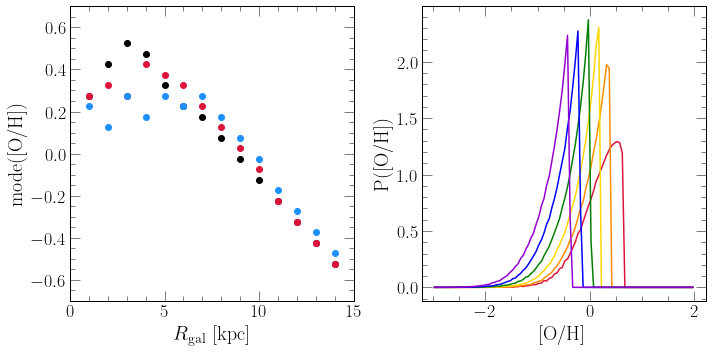

In [34]:
fig = plt.figure(figsize = (10, 5))
axes = []
for i in range(2): axes.append(fig.add_subplot(121 + i))
axes[0].set_xlabel(r"$R_\text{gal}$ [kpc]")
axes[0].set_ylabel(r"mode([O/H])")
axes[0].set_xlim([0, 15])
axes[0].set_ylim([-0.7, 0.7])
axes[1].set_xlabel(r"[O/H]")
axes[1].set_ylabel(r"P([O/H])")

colors = ["black", "crimson", "blue"]

radii = range(1, 15)
special = [3, 5, 7, 9, 11, 13]
special_colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
# stems = ["exp", "linexp", "risefall"]
colors = ["black", "crimson", "dodgerblue"]
# for i in range(len(stems)):
for i in range(len(scalings)):
    for j in range(len(radii)):
        with vice.output("./outputs/r_%d_kpc_scale%d" % (radii[j], scalings[i])) as out:
            oh = mode(out.mdf["bin_edge_left"] + [out.mdf["bin_edge_right"][-1]],
                out.mdf["dn/d[o/h]"])
            axes[0].scatter(radii[j], oh, c = colors[i])
            if not i and radii[j] in special:
                centers = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
                axes[1].plot(centers, out.mdf["dn/d[o/h]"], c = special_colors[special.index(radii[j])])
            else: pass

plt.tight_layout()
plt.show()

$$
\begin{align}
\frac{\partial Z_\alpha}{\partial R} &= \frac{\partial}{\partial R}\left[
\frac{y_\alpha}{1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}}
\right]
\\
&= \frac{-y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}
\left[
\frac{\partial \eta}{\partial R} -
\frac{1}{\tau_\text{sfh}}\frac{\partial \tau_\star}{\partial R} +
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} -
\frac{\partial \mu_\text{flow}}{\partial R}
\right]
\\
&= \frac{y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}
\left[
\frac{1}{\tau_\text{sfh}}\frac{\partial \tau_\star}{\partial R} -
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{\partial \mu_\text{flow}}{\partial R} -
\frac{\partial \eta}{\partial R}
\right].
\end{align}
$$

And now substituting in $\partial \tau_\star / \partial R = \left(N - 1\right)\tau_\star / R_g$ and $\partial \mu_\text{flow} / \partial R = \left(N - 1\right)\mu_\text{flow} / R_g - \tau_\star v_R / R^2$ from above:

$$
\frac{\partial Z_\alpha}{\partial R} =
\frac{y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}\left[
\left(\frac{\tau_\star}{\tau_\text{sfh}} + \mu_\text{flow}\right)\frac{N - 1}{R_g} -
\frac{\tau_\star v_R}{R^2} -
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} -
\frac{\partial \eta}{\partial R}
\right].
$$

Since this formalism is based on an exponential surface density gradient, $\partial Z_\alpha / \partial R = -Z_\alpha / R_\alpha$. Consequently:

$$
Z_\alpha =
\frac{y_\alpha R_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}\left[
\frac{\partial \eta}{\partial R} -
\left(\frac{\tau_\star}{\tau_\text{sfh}} + \mu_\text{flow}\right)\frac{N - 1}{R_g} +
\frac{\tau_\star v_R}{R^2} +
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R}
\right].
$$

Now imposing that $Z_\alpha \approx Z_{\alpha,\text{eq}} = y_\alpha / (1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow})$ yields the following condition:

$$
\frac{1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}}{R_\alpha} =
\frac{\partial \eta}{\partial R} -
\left(\frac{\tau_\star}{\tau_\text{sfh}} + \mu_\text{flow}\right)\frac{N - 1}{R_g} +
\frac{\tau_\star v_R}{R^2} +
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R}
$$

From this expression, it is now possible to isolate $\partial \eta / \partial R$ and $\partial \tau_\text{sfh} / \partial R$ on one side:

$$
Z_\alpha = t Z_{\alpha,\text{eq}} R \left[
% \frac{\partial Z_\alpha}{\partial R} = t Z_{\alpha,\text{eq}}\left[
\frac{-v_R}{R^2} +
\frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g}\right)
\right] -
Z_{\alpha,\text{eq}}\left(\frac{t}{\tau_\text{sfh}^2}\right)\frac{\partial \tau_\text{sfh}}{\partial R} -
Z_{\alpha,\text{eq}}\left(\frac{t}{\tau_\star}\right)\frac{\partial \eta}{\partial R}
\\
\begin{align}
\implies \frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{1}{\tau_\star}\frac{\partial \eta}{\partial R} &=
\frac{1}{t Z_{\alpha,\text{eq}}} \frac{\partial Z_\alpha}{\partial R} -
\frac{v_R}{R^2} +
\frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g}\right)
\\
&= \frac{1}{t Z_{\alpha,\text{eq}}} \left(\frac{-Z_\alpha}{R_\alpha}\right) -
\frac{v_R}{R^2} +
\frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g}\right).
\end{align}
$$

Where the substitution of $\partial Z_\alpha / \partial R = -Z_\alpha / R_\alpha$ comes from the fact that this formalism is based on the shape of the gradient being exponential in $Z_\alpha$ with a scale radius of $R_\alpha$. Recall however that $Z_\alpha = Z_{\alpha,\text{eq}}\left(1 - e^{-t / \tau_\text{eq}}\right)$, and therefore $Z_\alpha / Z_{\alpha,\text{eq}} = 1 - e^{-t / \tau_\text{eq}}$. Since I am considering the limiting case of $t \ll \tau_\text{eq}$ here, I take the limit as $t \rightarrow 0$ in the first term:

$$
\begin{align}
\lim_{t \rightarrow 0} \frac{Z_\alpha}{tZ_{\alpha,\text{eq}}} &=
\lim_{t \rightarrow 0} \frac{1 - e^{-t / \tau_\text{eq}}}{t}
\\
&\stackrel{\text{LH}}{=} \lim_{t \rightarrow 0} \frac{0 - e^{-t / \tau_\text{eq}}(-1 / \tau_\text{eq})}{1}
\\
&= \frac{1}{\tau_\text{eq}}
\end{align}
$$

This simplifies the above into the following coupled differential equation describing how $\tau_\text{sfh}$ and $\eta$ should scale with radius to produce a selected abundance gradient:

$$
\begin{align}
\frac{1}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{1}{\tau_\star} \frac{\partial \eta}{\partial R} &=
\frac{-1}{\tau_\text{eq}R_\alpha} -
\frac{v_R}{R^2} +
\frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g}\right)
\\
&= \frac{1}{\tau_\text{sfh} R_\alpha} -
\frac{1 + \eta - r - \mu_\text{flow}}{\tau_\star R_\alpha} -
\frac{v_R}{R^2} +
\frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g}\right)
\\
&= \frac{1 + \eta - r}{\tau_\star}\left(\frac{N - 1}{R_g} - \frac{1}{R_\alpha}\right) +
\frac{\mu_\text{flow}}{\tau_\star R_\alpha} -
\frac{v_R}{R^2} +
\frac{1}{\tau_\text{sfh} R_\alpha}.
\end{align}
$$

Substituting back in for $\mu_\text{flow}$ and the exponential increase in $\tau_\star$ with radius yields the following expression showing the input parameters:

$$
\begin{align}
\frac{1}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{e^{-(N - 1) R / R_g}}{\tau_{\star,0}} \frac{\partial \eta}{\partial R} &= 
\frac{1 + \eta - r}{\tau_{\star,0}}\left(\frac{N - 1}{R_g} - \frac{1}{R_\alpha}\right)e^{-(N - 1) R / R_g} +
v_R\left(\frac{1}{R R_\alpha} - \frac{1}{R_g R_\alpha} - \frac{1}{R_\alpha^2} - \frac{1}{R^2}\right) +
\frac{1}{\tau_\text{sfh} R_\alpha}.
\end{align}
$$

At this point, it is interesting to consider the form the equation has when mass loading is omitted (i.e., $\eta = 0$ everywhere):

$$
\frac{\partial \tau_\text{sfh}}{\partial R} =
\frac{\tau_\text{sfh}^2}{\tau_{\star,0}}\left(1 - r\right)
\left(\frac{N - 1}{R_g} - \frac{1}{R_\alpha}\right)e^{-(N - 1) R / R_g} +
v_r \tau_\text{sfh}^2
\left(\frac{1}{R R_\alpha} - \frac{1}{R_g R_\alpha} - \frac{1}{R_\alpha^2} - \frac{1}{R^2}\right) +
\frac{\tau_\text{sfh}}{R_\alpha},
$$

without radial gas flows (i.e., $v_R = 0$):

$$
\frac{\partial \tau_\text{sfh}}{\partial R} =
\frac{\tau_\text{sfh}^2}{\tau_{\star,0}}\left(1 - r\right)
\left(\frac{N - 1}{R_g} - \frac{1}{R_\alpha}\right)e^{-(N - 1) R / R_g} +
\frac{\tau_\text{sfh}}{R_\alpha},
$$

and for a linear Kennicutt-Schmidt relation (i.e., $N = 1$):

$$
\begin{align}
\frac{\partial \tau_\text{sfh}}{\partial R} &=
\frac{-\tau_\text{sfh}^2}{\tau_{\star,0}}
\left(\frac{1 - r}{R_\alpha}\right) +
\frac{\tau_\text{sfh}}{R_\alpha}
\\
&= \frac{\tau_\text{sfh}}{R_\alpha}
\left(1 - \frac{\tau_\text{sfh}\left(1 - r\right)}{\tau_{\star,0}}\right).
\end{align}
$$

### Variations in the Equilibrium Abundance

The change in $Z_{\alpha,\text{eq}}$ with radius is given by

$$
\begin{align}
\frac{\partial Z_{\alpha,\text{eq}}}{\partial R} &= \frac{\partial}{\partial R}
\left[\frac{y_\alpha}{1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}}\right]
\\
&= \frac{-y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}
\left[
\frac{\partial \eta}{\partial R} -
\frac{\partial}{\partial R} \left(\frac{\tau_\star}{\tau_\text{sfh}}\right) -
\frac{\partial \mu_\text{flow}}{\partial R}
\right]
\\
&= \frac{y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}
\left[
\frac{\partial}{\partial R} \left(\frac{\tau_\star}{\tau_\text{sfh}}\right) +
\frac{\partial \mu_\text{flow}}{\partial R} -
\frac{\partial \eta}{\partial R}
\right]
\\
&= \frac{y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}
\left[
\frac{1}{\tau_\text{sfh}} \frac{\partial \tau_\star}{\partial R} -
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\frac{\partial \mu_\text{flow}}{\partial R} -
\frac{\partial \eta}{\partial R}
\right].
\end{align}
$$

The ultimate goal is to obtain expressions for each of the partial derivatives with radius $\partial x / \partial R$ in the above expression, which will also be useful in computing $\partial \Gamma / \partial R$.

#### Variations in the SFE Timescale

The SFE timescale $\tau_\star$ is defined as the density ratio of the ISM to its star formation rate $\Sigma_g / \dot{\Sigma}_\star$. The Kennicutt-Schmidt scaling suggests, however, that there is a power-law relationship between the two surface densities:

$$
\dot{\Sigma}_\star \propto \Sigma_g^N,
$$

which then suggests the following scaling of $\tau_\star$ with $\Sigma_g$

$$
\tau_\star \equiv \frac{\Sigma_g}{\dot{\Sigma}_\star}
\propto \frac{\Sigma_g}{\Sigma_g^N}
= \Sigma_g^{1 - N}.
$$

Substituting in normalization factors, the exact scaling can be expressed as

$$
\tau_\star = \tau_{\star,0} \left(\frac{\Sigma_g}{\Sigma_{g,0}}\right)^{1 - N}.
$$

Since this formalism is based on the gas surface density following an exponential profile with scale radius $R_g$, we can derive the exact expression for $\partial \tau_\star / \partial R$. Letting $\Sigma_{g,0}$ be the surface density of gas at $R = 0$:

$$
\begin{align}
\tau_\star &= \tau_{\star,0} \left(e^{-R / R_g}\right)^{1 - N}
\\
&= \tau_{\star,0} e^{(N - 1)R / R_g}
\\
\implies \frac{\partial \tau_\star}{\partial R} &=
\left(\frac{N - 1}{R_g}\right)\tau_{\star,0} e^{(N - 1)R / R_g}
\\
&= \left(\frac{N - 1}{R_g}\right) \tau_\star
\end{align}
$$

Though the Johnson et al. (2021) model used a broken power-law for their $\dot{\Sigma}_\star - \Sigma_g$ relation, a single power-law is reasonable for the purposes of an analytic approximation. This expression can also be easily extended to the broken power-law by introducing breaks in the value of $N$.

#### Variations in the metal flow parameter

The metal flow parameter $\mu_\text{flow}$ is given by

$$
\mu_\text{flow} = \tau_\star v_R \left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right).
$$

It's derivative with respect to radius therefore depends on $\partial \tau_\star / \partial R$ and, by extension, the assumed power-law index $N$:

$$
\begin{align}
\frac{\partial \mu_\text{flow}}{\partial R} &= \frac{\partial \tau_\star}{\partial R} v_R
\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
\frac{\tau_\star v_R}{R^2}
\\
&= \left(\frac{N - 1}{R_g}\right) \tau_\star v_R
\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
\tau_\star \frac{v_r}{R^2}
\\
&= \tau_\star v_R \left[
\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
\frac{1}{R^2}
\right].
% &= \left(\frac{N - 1}{R_g}\right) \tau_\star v_R
% \left(\frac{1}{R} - \frac{1}{R_g}\right) -
% \tau_\star \frac{v_r}{R^2} -
% \left(\frac{N - 1}{R_g}\right) \frac{\tau_\star v_R}{R_\alpha},
\end{align}
$$

<!-- If the above were a stand-alone expression, there would be better ways to simplify it, though the goal here is to isolate $R_\alpha$. -->

#### Combining Terms

Putting it all together, I get the following expression for $\partial Z_{\alpha,\text{eq}} / \partial R$:

$$
\begin{align}
\frac{\partial Z_{\alpha,\text{eq}}}{\partial R} &=
\frac{y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \mu_\text{flow}\right)^2}
\left[
\left(\frac{N - 1}{R_g}\right) \frac{\tau_\star}{\tau_\text{sfh}} -
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\tau_\star v_R \left[
\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
\frac{1}{R^2}
\right] -
\frac{\partial \eta}{\partial R}
\right]
\\
% &= \frac{y_\alpha}{\left(1 + \eta - r - \tau_\star / \tau_\text{sfh} - \gamma_\text{flow} +
% \tau_\star v_R / R_\alpha\right)^2}
% \left[
% \left(\frac{N - 1}{R_g}\right) \frac{\tau_\star}{\tau_\text{sfh}} -
% \frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
% \tau_\star v_R \left[
% \left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
% \frac{1}{R^2}
% \right] -
% \frac{\partial \eta}{\partial R}
% \right],
\end{align}
$$

<!-- where I have substituted $\mu_\text{flow} = \gamma_\text{flow} - \tau_\star v_R / R_\alpha$ into the final equality to expose every appearance of $R_\alpha$. -->

### Variations in $\Gamma$

The derivative of $\Gamma$ with respect to radius is given by

$$
\begin{align}
\frac{\partial \Gamma}{\partial R} &=
\frac{1}{\tau_\star^2}\left(\tau_\star \left(\frac{\partial \eta}{\partial R} -
\frac{\partial \mu_\text{flow}}{\partial R}\right) -
\left(1 + \eta - r - \mu_\text{flow}\right)\frac{\partial \tau_\star}{\partial R}
\right) + \frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R}
\\
&= \frac{1}{\tau_\star^2}\left(\tau_\star \left(\frac{\partial \eta}{\partial R} -
\frac{\partial \mu_\text{flow}}{\partial R}\right) -
\left(1 + \eta - r - \mu_\text{flow}\right)\left(\frac{N - 1}{R_g}\right)\tau_\star
\right) + \frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R}
\\
&= \frac{1}{\tau_\star}\left[\frac{\partial \eta}{\partial R} -
\frac{\partial \mu_\text{flow}}{\partial R} -
\left(1 + \eta - r - \mu_\text{flow}\right)\left(\frac{N - 1}{R_g}\right)
\right] + \frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R}
\\
&= \frac{1}{\tau_\star}\left[\frac{\partial \eta}{\partial R} -
\left(1 + \eta - r - \mu_\text{flow}\right)\left(\frac{N - 1}{R_g}\right)
\right] + \frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
\frac{1}{\tau_\star}\frac{\partial \mu_\text{flow}}{\partial R}
\\
&= \frac{1}{\tau_\star}\left[\frac{\partial \eta}{\partial R} -
\left(1 + \eta - r - \gamma_\text{flow} + \frac{\tau_\star v_R}{R_\alpha}\right)\left(\frac{N - 1}{R_g}\right)
\right] + \frac{1}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
v_R\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g}\right) +
\frac{v_r}{R^2} +
\left(\frac{N - 1}{R_g}\right) \frac{v_R}{R_\alpha},
\end{align}
$$

where, as for $\partial Z_{\alpha,\text{eq}} / \partial R$ below, I have substituted in $\mu_\text{flow} = \gamma_\text{flow} - \tau_\star v_R / R_\alpha$ into the final equality to expose every appearance of $R_\alpha$.

### Combining Terms

Recall that this formalism already assumes an abundance gradient $Z_\alpha \propto e^{-R / R_\alpha}$. The gradient itself is then given by $Z_\alpha / R_\alpha$ at a given $Z_\alpha$. Combining terms, the goal is to isolate $R_\alpha$ and predict the gradient that will arise given assumptions for the remaining GCE parameters.

It is notationally convenient here to define another dimensionless parameter:

$$
\xi \equiv 1 + \eta - r - \gamma_\text{flow},
$$

such that the predicted gradient can be expressed as

$$
\begin{align}
\frac{\partial Z_\alpha}{\partial R} &= \frac{\partial Z_{\alpha,\text{eq}}}{\partial R}
\left(1 - e^{-\Gamma T}\right)
+ Z_{\alpha,\text{eq}}Te^{-\Gamma T}\frac{\partial \Gamma}{\partial R}
\\
\frac{-Z_\alpha}{R_\alpha} &=
\frac{
    y_\alpha\left(1 - e^{-\Gamma T}\right)
}{
    \left(\xi - \tau_\star / \tau_\text{sfh} + \tau_\star v_R / R_\alpha\right)^2
}\left[
\left(\frac{N - 1}{R_g}\right) \frac{\tau_\star}{\tau_\text{sfh}} -
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\tau_\star v_R \left[
\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
\frac{1}{R^2}
\right] -
\frac{\partial \eta}{\partial R}
\right] 
\\
&\qquad+ \frac{y_\alpha e^{-\Gamma T}}{\xi - \tau_\star / \tau_\text{sfh} + \tau_\star v_R / R_\alpha}
\left(\frac{T}{\tau_\star}\right)
\left[\frac{\partial \eta}{\partial R} -
\left(\xi + \frac{\tau_\star v_R}{R_\alpha}\right)\left(\frac{N - 1}{R_g}\right)
\right] + \frac{T}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
T v_R\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g}\right)
\\
&\qquad+ \frac{T v_r}{R^2} +
T\left(\frac{N - 1}{R_g}\right) \frac{v_R}{R_\alpha}
\\
&=
\frac{
    y_\alpha\left(1 - e^{-\Gamma T}\right)
}{
    \left(\xi - \tau_\star / \tau_\text{sfh} + \tau_\star v_R / R_\alpha\right)^2
}\left[
\left(\frac{N - 1}{R_g}\right) \frac{\tau_\star}{\tau_\text{sfh}} -
\frac{\tau_\star}{\tau_\text{sfh}^2} \frac{\partial \tau_\text{sfh}}{\partial R} +
\tau_\star v_R \left[
\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g} - \frac{1}{R_\alpha}\right) -
\frac{1}{R^2}
\right] -
\frac{\partial \eta}{\partial R}
\right] 
\\
&\qquad+ \frac{y_\alpha e^{-\Gamma T}}{\xi - \tau_\star / \tau_\text{sfh} + \tau_\star v_R / R_\alpha}
\left(\frac{T}{\tau_\star}\right)
\left[\frac{\partial \eta}{\partial R} -
\left(\xi + \frac{\tau_\star v_R}{R_\alpha}\right)\left(\frac{N - 1}{R_g}\right)
\right] + \frac{T}{\tau_\text{sfh}^2}\frac{\partial \tau_\text{sfh}}{\partial R} -
T v_R\left(\frac{N - 1}{R_g}\right)\left(\frac{1}{R} - \frac{1}{R_g}\right)
\\
&\qquad+ \frac{T v_r}{R^2} +
\frac{T v_R}{R_\alpha}\left(\frac{N - 1}{R_g}\right)
\end{align}
$$